In [ ]:
pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 11.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=64342825fd98683805a25e56de35ac2803537a00547d05258f778546b149d5ed
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines.statistics import logrank_test
from scipy.stats import gaussian_kde



In [ ]:
pd.set_option('display.max_columns', None)

# Etapas de Analise

1. Apresentação dos dados

Vamos trabalhar com uma base de dados referente a pacientes com cancer de mama.

In [ ]:
df = pd.read_csv('/content/Breast Cancer METABRIC.csv')

In [ ]:
df['Cancer Type Detailed'].value_counts()

,count
Cancer Type Detailed,
Breast Invasive Ductal Carcinoma,1865
Breast Mixed Ductal and Lobular Carcinoma,269
Breast Invasive Lobular Carcinoma,192
Invasive Breast Carcinoma,133
Breast Invasive Mixed Mucinous Carcinoma,25
Breast,21
Breast Angiosarcoma,2
Metaplastic Breast Cancer,2


In [ ]:
df_filtered = df[df['Cancer Type Detailed'] == 'Breast Invasive Ductal Carcinoma']

Vamos analisar apenas os casos de cancer: Breast Invasive Ductal Carcinoma

In [ ]:
df_filtered['Tumor Stage'].value_counts()

,count
Tumor Stage,
2.0,759
1.0,440
3.0,101
4.0,8
0.0,3


In [ ]:
df_filtered = df_filtered[ df_filtered['Tumor Stage'].isin([2,3]) ]

Para uma analise mais vamos olhar apenas os paicentes com cancer tipo 2 e 3 pois é um estagio onde o tumor cresceu nos tecidos próximos e pode ter se espalhado para os gânglios linfáticos. O nosso objetivo será ver quais tratamentos trazem uma taxa maior de sobrevivencia.


In [ ]:
df_filtered = df_filtered.iloc[:, [1, 2, 6, 10, 11, 13, 15, 19, 23, 24, 25, 26, 29, 31, 32, 33]].dropna()

In [ ]:
print('Tempo que os pacientes sobreviveram dentro do estudo :{} - {} meses'.format(df_filtered['Overall Survival (Months)'].min(), df_filtered['Overall Survival (Months)'].max()))


Tempo que os pacientes sobreviveram dentro do estudo :1.233333333 - 351.0 meses


In [ ]:
df_filtered["Patient's Vital Status"].value_counts()

,count
Patient's Vital Status,
Died of Disease,276
Living,274
Died of Other Causes,152



*   O objetivo da analise é conseguirmos saber a eficacia de cada um dos 3 tipos de terapia em pacientes que estão nos estagio 2 e 3 do tumor de Breast Invasive Ductal Carcinoma.

*   A nossa maostra tem 702 pacientes.

*   A nossa amostra não tem um tempo especifico do estudo, poissão amostras de diversos pacientes ao longo do tempo. Entretanto, podemos informar que o tempo do paciente de maior sobrevivencia é de 351 meses.

*   Temos 276 mortes pela doença ( Falha ). Temos 274 de pacientes que sobreviveram até o momento que a amostra foi retirada e temos 152 que morreram de uma forma diferente ( Censura ).

*   Temos dois tipos de censura: A censura a direita para os que estão vivos e a censura intervalar para os que morreram por outras causas.

*   Para o estudo foi escolhido as seguintes covariaveis:

age_at_diagnosis : Age of the patient at diagnosis time

type_of_breast_surgery : Breast cancer surgery type: 1- MASTECTOMY, which refers to a surgery to remove all breast tissue from a breast as a way to treat or prevent breast cancer. 2- BREAST CONSERVING, which refers to a urgery where only the part of the breast that has cancer is removed.

chemotherapy : Whether or not the patient had chemotherapy as a treatment (yes/no).

er_status	:	Cancer cells are positive or negative for estrogen receptors.

neoplasm_histologic_grade	:	Determined by pathology by looking the nature of the cells, do they look aggressive or not (It takes a value from 1 to 3).

her2_status	:	Whether the cancer is positive or negative for HER2.

tumor_other_histologic_subtype :	Type of the cancer based on microscopic examination of the cancer tissue (It takes a value of 'Ductal/NST', 'Mixed', 'Lobular', 'Tubular/ cribriform', 'Mucinous', 'Medullary', 'Other', 'Metaplastic' ).

hormone_therapy	:	Whether or not the patient had hormonal as a treatment (yes/no).

lymph_nodes_examined_positive	:	To take samples of the lymph node during the surgery and see if there were involved by the cancer.

overall_survival_months	:	Duration from the time of the intervention to death.

overall_survival	:	Target variable wether the patient is alive of dead.
pr_status	object	Cancer cells are positive or negative for progesterone receptors.

radio_therapy	:	Whether or not the patient had radio as a treatment (yes/no).

tumor_size	:	Tumor size measured by imaging techniques.

tumor_stage	:	Stage of the cancer based on the involvement of surrounding structures, lymph nodes and distant spread.

death_from_cancer	:	Wether the patient's death was due to cancer or not (yes/no).

In [ ]:
df_filtered

,Age at Diagnosis,Type of Breast Surgery,Chemotherapy,ER Status,Neoplasm Histologic Grade,HER2 Status,Hormone Therapy,Lymph nodes examined positive,Overall Survival (Months),Overall Survival Status,PR Status,Radio Therapy,Sex,Tumor Size,Tumor Stage,Patient's Vital Status
0,75.65,Mastectomy,No,Positive,3.0,Negative,Yes,10.0,140.500000,Living,Negative,Yes,Female,22.0,2.0,Living
2,48.87,Mastectomy,Yes,Positive,2.0,Negative,Yes,1.0,163.700000,Deceased,Positive,No,Female,15.0,2.0,Died of Disease
6,56.45,Breast Conserving,Yes,Positive,2.0,Negative,Yes,1.0,164.333333,Living,Positive,Yes,Female,10.0,2.0,Living
10,86.41,Breast Conserving,No,Positive,3.0,Negative,Yes,1.0,36.566667,Deceased,Negative,Yes,Female,16.0,2.0,Died of Other Causes
14,45.27,Mastectomy,Yes,Negative,3.0,Negative,No,3.0,164.900000,Living,Positive,Yes,Female,19.0,2.0,Living
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1682,56.93,Breast Conserving,No,Positive,2.0,Negative,Yes,2.0,221.200000,Living,Negative,Yes,Female,20.0,2.0,Living
1688,49.67,Mastectomy,No,Positive,3.0,Negative,No,0.0,147.766667,Deceased,Negative,No,Female,22.0,2.0,Died of Disease
1689,58.83,Breast Conserving,Yes,Negative,3.0,Negative,No,2.0,221.933333,Living,Negative,Yes,Female,20.0,2.0,Living
1690,66.94,Mastectomy,Yes,Negative,3.0,Positive,No,31.0,35.466667,Deceased,Positive,Yes,Female,10.0,2.0,Died of Disease


# Construção da curva de sobrevivencia e Teste log-rank

Para os testes de sobrevivencia vamos dividir em grupos de pacientes que não fizeram nenhum tratamento, fizeram um tratamento unic, fizeram um tratamento duplo e fizeram um tratamento com 3 procedimentos diferentes. O objetivo é comparar a sobrevivencia entre estes grupos e conseguir alguma resposta se o numero de tratamentos influencia na sobrevivencia de pacientes com cancer no estagio 2 ou 3.

In [ ]:
df_filtered['event'] = np.where(df_filtered["Patient's Vital Status"] == 'Died of Disease', 1, 0)

In [ ]:
df_filtered['Chemotherapy'] = np.where(df_filtered['Chemotherapy'] == 'No', 0, 1)
df_filtered['Hormone Therapy'] = np.where(df_filtered['Hormone Therapy'] == 'No', 0, 1)
df_filtered['Radio Therapy'] = np.where(df_filtered['Radio Therapy'] == 'No', 0, 1)

# Definição das condições
condicoes = [
    df_filtered['Chemotherapy'] + df_filtered['Hormone Therapy'] + df_filtered['Radio Therapy'] == 1,
    df_filtered['Chemotherapy'] + df_filtered['Hormone Therapy'] + df_filtered['Radio Therapy'] == 2,
    df_filtered['Chemotherapy'] + df_filtered['Hormone Therapy'] + df_filtered['Radio Therapy'] == 3,
    df_filtered['Chemotherapy'] + df_filtered['Hormone Therapy'] + df_filtered['Radio Therapy'] == 0
]

# Definição dos valores correspondentes
valores = ['Unico', 'Duplo', 'Triplo', 'Nenhum']

# Cria a nova coluna
df_filtered['Qtd tratamentos'] = np.select(condicoes, valores, default='Desconhecido')

df_filtered


,Age at Diagnosis,Type of Breast Surgery,Chemotherapy,ER Status,Neoplasm Histologic Grade,HER2 Status,Hormone Therapy,Lymph nodes examined positive,Overall Survival (Months),Overall Survival Status,PR Status,Radio Therapy,Sex,Tumor Size,Tumor Stage,Patient's Vital Status,event,Qtd tratamentos
0,75.65,Mastectomy,0,Positive,3.0,Negative,1,10.0,140.500000,Living,Negative,1,Female,22.0,2.0,Living,0,Duplo
2,48.87,Mastectomy,1,Positive,2.0,Negative,1,1.0,163.700000,Deceased,Positive,0,Female,15.0,2.0,Died of Disease,1,Duplo
6,56.45,Breast Conserving,1,Positive,2.0,Negative,1,1.0,164.333333,Living,Positive,1,Female,10.0,2.0,Living,0,Triplo
10,86.41,Breast Conserving,0,Positive,3.0,Negative,1,1.0,36.566667,Deceased,Negative,1,Female,16.0,2.0,Died of Other Causes,0,Duplo
14,45.27,Mastectomy,1,Negative,3.0,Negative,0,3.0,164.900000,Living,Positive,1,Female,19.0,2.0,Living,0,Duplo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1682,56.93,Breast Conserving,0,Positive,2.0,Negative,1,2.0,221.200000,Living,Negative,1,Female,20.0,2.0,Living,0,Duplo
1688,49.67,Mastectomy,0,Positive,3.0,Negative,0,0.0,147.766667,Deceased,Negative,0,Female,22.0,2.0,Died of Disease,1,Nenhum
1689,58.83,Breast Conserving,1,Negative,3.0,Negative,0,2.0,221.933333,Living,Negative,1,Female,20.0,2.0,Living,0,Duplo
1690,66.94,Mastectomy,1,Negative,3.0,Positive,0,31.0,35.466667,Deceased,Positive,1,Female,10.0,2.0,Died of Disease,1,Duplo


In [ ]:
df_filtered['Qtd tratamentos'].value_counts()

#Separamos o nosso dataset em 4 grupos diferentes, de acordo com quantidade de tratamentos que essa pessoa fez para enfrenttar o cancer.

,count
Qtd tratamentos,
Duplo,374
Unico,172
Triplo,100
Nenhum,56


In [ ]:
group_a = df_filtered[df_filtered['Qtd tratamentos'] == 'Nenhum']
group_b = df_filtered[df_filtered['Qtd tratamentos'] == 'Unico']
group_c = df_filtered[df_filtered['Qtd tratamentos'] == 'Duplo']
group_d = df_filtered[df_filtered['Qtd tratamentos'] == 'Triplo']

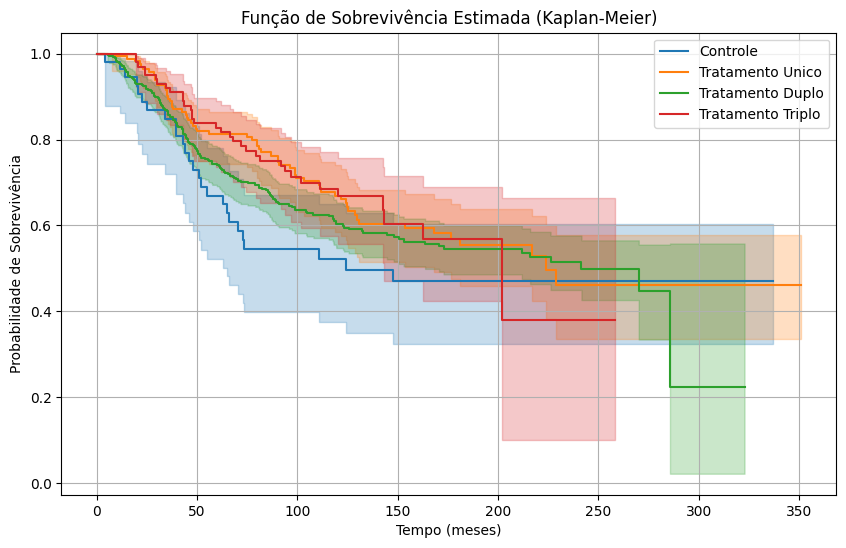

In [ ]:
# Estimador de Kaplan-Meier para cada grupo
kmfit_a = KaplanMeierFitter()
kmfit_b = KaplanMeierFitter()
kmfit_c = KaplanMeierFitter()
kmfit_d = KaplanMeierFitter()

# Ajustar os modelos
kmfit_a.fit(durations=group_a["Overall Survival (Months)"], event_observed=group_a["event"], label="Controle")
kmfit_b.fit(durations=group_b["Overall Survival (Months)"], event_observed=group_b["event"], label="Tratamento Unico")
kmfit_c.fit(durations=group_c["Overall Survival (Months)"], event_observed=group_c["event"], label="Tratamento Duplo")
kmfit_d.fit(durations=group_d["Overall Survival (Months)"], event_observed=group_d["event"], label="Tratamento Triplo")

# Visualização
plt.figure(figsize=(10, 6))
kmfit_a.plot_survival_function(ci_show=True)
kmfit_b.plot_survival_function(ci_show=True)
kmfit_c.plot_survival_function(ci_show=True)
kmfit_d.plot_survival_function(ci_show=True)

plt.title("Função de Sobrevivência Estimada (Kaplan-Meier)")
plt.xlabel("Tempo (meses)")
plt.ylabel("Probabilidade de Sobrevivência")
plt.grid(True)
plt.show()

Para o teste log rank vamos comparar todas as nossas curvas entre si. Assim iremos saber se há uma diferença estatistica em fazer uma quantidade especifica de tratamentos.

In [ ]:
# Teste de Log-Rank
logrank_result = logrank_test(
    group_a["Overall Survival (Months)"], group_b["Overall Survival (Months)"],
    event_observed_A=group_a["event"], event_observed_B=group_b["event"]
)

# Exibindo o resultado do teste
print("Resultado do Teste de Log-Rank - Grupos Nenhum e Unico")
print(f"Estatística do teste: {logrank_result.test_statistic:.4f}")
print(f"Valor-p: {logrank_result.p_value:.4f}")

# Interpretação
if logrank_result.p_value < 0.05:
    print("Rejeitamos a hipótese nula: As curvas de sobrevivência são significativamente diferentes.")
else:
    print("Não rejeitamos a hipótese nula: Não há diferença significativa entre as curvas de sobrevivência.")

Resultado do Teste de Log-Rank - Grupos Nenhum e Unico
Estatística do teste: 2.2327
Valor-p: 0.1351
Não rejeitamos a hipótese nula: Não há diferença significativa entre as curvas de sobrevivência.


In [ ]:
# Teste de Log-Rank
logrank_result = logrank_test(
    group_a["Overall Survival (Months)"], group_c["Overall Survival (Months)"],
    event_observed_A=group_a["event"], event_observed_B=group_c["event"]
)

# Exibindo o resultado do teste
print("Resultado do Teste de Log-Rank - Grupos Nenhum e Duplo")
print(f"Estatística do teste: {logrank_result.test_statistic:.4f}")
print(f"Valor-p: {logrank_result.p_value:.4f}")

# Interpretação
if logrank_result.p_value < 0.05:
    print("Rejeitamos a hipótese nula: As curvas de sobrevivência são significativamente diferentes.")
else:
    print("Não rejeitamos a hipótese nula: Não há diferença significativa entre as curvas de sobrevivência.")

Resultado do Teste de Log-Rank - Grupos Nenhum e Duplo
Estatística do teste: 0.6851
Valor-p: 0.4078
Não rejeitamos a hipótese nula: Não há diferença significativa entre as curvas de sobrevivência.


In [ ]:
# Teste de Log-Rank
logrank_result = logrank_test(
    group_a["Overall Survival (Months)"], group_d["Overall Survival (Months)"],
    event_observed_A=group_a["event"], event_observed_B=group_d["event"]
)

# Exibindo o resultado do teste
print("Resultado do Teste de Log-Rank - Grupos Nenhum e Triplo")
print(f"Estatística do teste: {logrank_result.test_statistic:.4f}")
print(f"Valor-p: {logrank_result.p_value:.4f}")

# Interpretação
if logrank_result.p_value < 0.05:
    print("Rejeitamos a hipótese nula: As curvas de sobrevivência são significativamente diferentes.")
else:
    print("Não rejeitamos a hipótese nula: Não há diferença significativa entre as curvas de sobrevivência.")

Resultado do Teste de Log-Rank - Grupos Nenhum e Triplo
Estatística do teste: 2.8680
Valor-p: 0.0904
Não rejeitamos a hipótese nula: Não há diferença significativa entre as curvas de sobrevivência.


In [ ]:
# Teste de Log-Rank
logrank_result = logrank_test(
    group_b["Overall Survival (Months)"], group_c["Overall Survival (Months)"],
    event_observed_A=group_b["event"], event_observed_B=group_c["event"]
)

# Exibindo o resultado do teste
print("Resultado do Teste de Log-Rank - Grupos Unico e Duplo")
print(f"Estatística do teste: {logrank_result.test_statistic:.4f}")
print(f"Valor-p: {logrank_result.p_value:.4f}")

# Interpretação
if logrank_result.p_value < 0.05:
    print("Rejeitamos a hipótese nula: As curvas de sobrevivência são significativamente diferentes.")
else:
    print("Não rejeitamos a hipótese nula: Não há diferença significativa entre as curvas de sobrevivência.")

Resultado do Teste de Log-Rank - Grupos Unico e Duplo
Estatística do teste: 1.0249
Valor-p: 0.3114
Não rejeitamos a hipótese nula: Não há diferença significativa entre as curvas de sobrevivência.


In [ ]:
# Teste de Log-Rank
logrank_result = logrank_test(
    group_b["Overall Survival (Months)"], group_d["Overall Survival (Months)"],
    event_observed_A=group_b["event"], event_observed_B=group_d["event"]
)

# Exibindo o resultado do teste
print("Resultado do Teste de Log-Rank - Grupos Unico e Triplo")
print(f"Estatística do teste: {logrank_result.test_statistic:.4f}")
print(f"Valor-p: {logrank_result.p_value:.4f}")

# Interpretação
if logrank_result.p_value < 0.05:
    print("Rejeitamos a hipótese nula: As curvas de sobrevivência são significativamente diferentes.")
else:
    print("Não rejeitamos a hipótese nula: Não há diferença significativa entre as curvas de sobrevivência.")

Resultado do Teste de Log-Rank - Grupos Unico e Triplo
Estatística do teste: 0.0029
Valor-p: 0.9573
Não rejeitamos a hipótese nula: Não há diferença significativa entre as curvas de sobrevivência.


In [ ]:
# Teste de Log-Rank
logrank_result = logrank_test(
    group_c["Overall Survival (Months)"], group_d["Overall Survival (Months)"],
    event_observed_A=group_c["event"], event_observed_B=group_d["event"]
)

# Exibindo o resultado do teste
print("Resultado do Teste de Log-Rank - Grupos Duplo e Triplo")
print(f"Estatística do teste: {logrank_result.test_statistic:.4f}")
print(f"Valor-p: {logrank_result.p_value:.4f}")

# Interpretação
if logrank_result.p_value < 0.05:
    print("Rejeitamos a hipótese nula: As curvas de sobrevivência são significativamente diferentes.")
else:
    print("Não rejeitamos a hipótese nula: Não há diferença significativa entre as curvas de sobrevivência.")

Resultado do Teste de Log-Rank - Grupos Duplo e Triplo
Estatística do teste: 1.1878
Valor-p: 0.2758
Não rejeitamos a hipótese nula: Não há diferença significativa entre as curvas de sobrevivência.


### Descrição e analise dos resultados

Dividimos o nosso dataset em 4 grupos de acordo com o numero de tratamentos que o paciente fez para enfrentar o cancer, desde nenhum até 3 tipos diferentes de tratamentos.

No gráfico das curvas de sobrevivencia da para perceber que as curvas dos pacientes que fizeram algum tipo de tratamento são melhores do que os que não fizeram nenhum tipo. Continuando olhando o gráfico, percebesse que os pacientes que fizeram 2 ou 3 tratamentos diferentes é levemente superior aos pacientes que fizeram apenas 1. Entretanto, aqui estamos ignorando o teste log rank e estamos apenas fazendo análises visuais.

O teste Log-Rank foi feito comparando em pares todas as curvas de sobrevivencia de modo que cada curva seja comparada com as outras 3 curvas. Analisando os resultados do teste, podemos dizer que estatisticamente as curvas não são diferentes, ou seja, não podemos chegar a uma conclusão sobre qual dos grupos tem uma melhor taxa de sobrevivencia com os dados que temos.





# Construção da Curva de risco acumulado e Taxa de risco instantanea

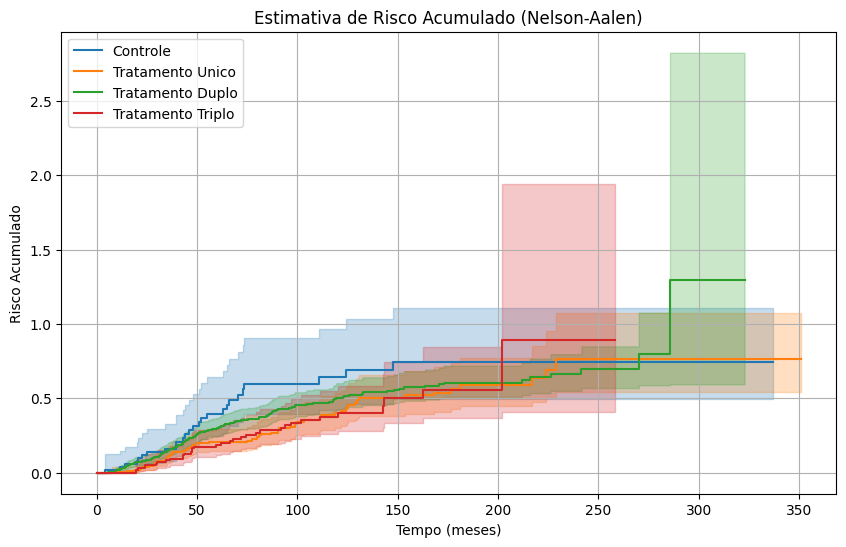

In [ ]:
# Estimador de Nelson-Aalen para cada grupo
naf_a = NelsonAalenFitter()
naf_b = NelsonAalenFitter()
naf_c = NelsonAalenFitter()
naf_d = NelsonAalenFitter()

# Ajustar os modelos
naf_a.fit(durations=group_a["Overall Survival (Months)"], event_observed=group_a["event"], label="Controle")
naf_b.fit(durations=group_b["Overall Survival (Months)"], event_observed=group_b["event"], label="Tratamento Unico")
naf_c.fit(durations=group_c["Overall Survival (Months)"], event_observed=group_c["event"], label="Tratamento Duplo")
naf_d.fit(durations=group_d["Overall Survival (Months)"], event_observed=group_d["event"], label="Tratamento Triplo")

# Visualização
plt.figure(figsize=(10, 6))
naf_a.plot_cumulative_hazard(ci_show=True)
naf_b.plot_cumulative_hazard(ci_show=True)
naf_c.plot_cumulative_hazard(ci_show=True)
naf_d.plot_cumulative_hazard(ci_show=True)

plt.title("Estimativa de Risco Acumulado (Nelson-Aalen)")
plt.xlabel("Tempo (meses)")
plt.ylabel("Risco Acumulado")
plt.grid(True)
plt.show()

<ipython-input-122-979da002400e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  observed_times_a = group_a[df_filtered["event"] == 1]["Overall Survival (Months)"].values #grupo controle
<ipython-input-122-979da002400e>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  observed_times_b = group_b[df_filtered["event"] == 1]["Overall Survival (Months)"].values #grupo esteróide
<ipython-input-122-979da002400e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  observed_times_c = group_c[df_filtered["event"] == 1]["Overall Survival (Months)"].values #grupo esteróide
<ipython-input-122-979da002400e>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  observed_times_d = group_d[df_filtered["event"] == 1]["Overall Survival (Months)"].values #grupo esteróide


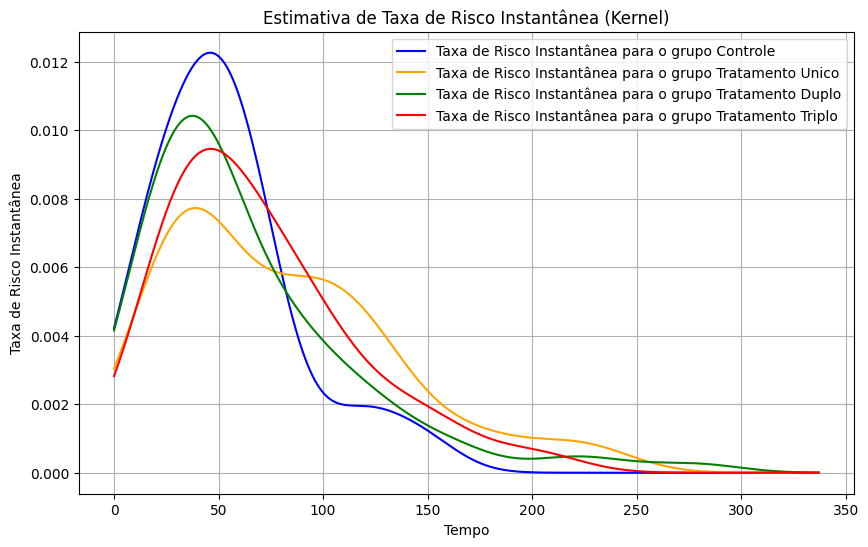

In [ ]:
# Filtrar apenas os tempos e eventos observados em cada grupo

observed_times_a = group_a[df_filtered["event"] == 1]["Overall Survival (Months)"].values #grupo controle
observed_times_b = group_b[df_filtered["event"] == 1]["Overall Survival (Months)"].values #grupo esteróide
observed_times_c = group_c[df_filtered["event"] == 1]["Overall Survival (Months)"].values #grupo esteróide
observed_times_d = group_d[df_filtered["event"] == 1]["Overall Survival (Months)"].values #grupo esteróide

# Kernel Density Estimation (Estimador de Kernel)
kde_a = gaussian_kde(observed_times_a, bw_method='scott')  # Suavização automática usando 'scott' grupo controle
kde_b = gaussian_kde(observed_times_b, bw_method='scott')  # Suavização automática usando 'scott' grupo esteróide
kde_c = gaussian_kde(observed_times_c, bw_method='scott')  # Suavização automática usando 'scott' grupo esteróide
kde_d = gaussian_kde(observed_times_d, bw_method='scott')  # Suavização automática usando 'scott' grupo esteróide

# Criar valores de tempo para estimar a densidade
time_grid = np.linspace(0, max(group_a["Overall Survival (Months)"]), 1000)  # Valores entre 0 e o maior tempo

# Calcular a densidade estimada (taxa de risco instantânea)
risk_density_a = kde_a(time_grid)
risk_density_b = kde_b(time_grid)
risk_density_c = kde_c(time_grid)
risk_density_d = kde_d(time_grid)

# Plotar a taxa de risco instantânea
plt.figure(figsize=(10, 6))
plt.plot(time_grid, risk_density_a, label="Taxa de Risco Instantânea para o grupo Controle", color="blue")
plt.plot(time_grid, risk_density_b, label="Taxa de Risco Instantânea para o grupo Tratamento Unico", color="orange")
plt.plot(time_grid, risk_density_c, label="Taxa de Risco Instantânea para o grupo Tratamento Duplo", color="green")
plt.plot(time_grid, risk_density_d, label="Taxa de Risco Instantânea para o grupo Tratamento Triplo", color="red")

plt.title("Estimativa de Taxa de Risco Instantânea (Kernel)")
plt.xlabel("Tempo")
plt.ylabel("Taxa de Risco Instantânea")
plt.grid(True)
plt.legend()
plt.show()

Olhando as curvas de risco acumulado conseguimos ver que os pacientes sem tratamento tem um risco maior de falecimento por cancer, entretanto o seu risco fica menor quando passamos de 200 meses.

A afirmação do paragráfo anterior é explicada quando olhamos o gráfico de risco instantâneo. Quando o paciente não faz um tratamento contra o cancer existe um risco instantaneo de mortalidade maior que os pacientes que fizeram algum tratamento até apróximadamente 75 meses, quando passamos disso o risco instantâneo se inverte. Talvez seja alguma seleção natural dos pacientes ou são pacientes que tem alguma caracteristica que os façam ser mais fortes, e como eles não opitaram por fazer tratamentos de cancer agressivos como a quimio ou de radio, o corpo conseguiu se recuperar normalmente.



# Ajuste de modelos Paramétricos

## Modelo Exponencial

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import ExponentialFitter, KaplanMeierFitter

In [167]:
# Ajustar o modelo exponencial
exp_fitter_a = ExponentialFitter()
exp_fitter_b = ExponentialFitter()
exp_fitter_c = ExponentialFitter()
exp_fitter_d = ExponentialFitter()

exp_fitter_a.fit(group_a['Overall Survival (Months)'], event_observed=group_a['event'])
exp_fitter_b.fit(group_b['Overall Survival (Months)'], event_observed=group_b['event'])
exp_fitter_c.fit(group_c['Overall Survival (Months)'], event_observed=group_c['event'])
exp_fitter_d.fit(group_d['Overall Survival (Months)'], event_observed=group_d['event'])


# Exibir os parâmetros do modelo
print("\nParâmetros do modelo exponencial - Grupo Nenhum tratamento:")
print(exp_fitter_a.summary)

print("\nParâmetros do modelo exponencial - Grupo unico tratamento:")
print(exp_fitter_b.summary)

print("\nParâmetros do modelo exponencial - Grupo Duplo tratamento:")
print(exp_fitter_c.summary)

print("\nParâmetros do modelo exponencial - Grupo Triplo tratamento:")
print(exp_fitter_d.summary)


Parâmetros do modelo exponencial - Grupo Nenhum tratamento:
               coef   se(coef)  coef lower 95%  coef upper 95%  cmp to  \
lambda_  244.173047  47.886268      150.317686      338.028409     0.0   

               z             p   -log2(p)  
lambda_  5.09902  3.414162e-07  21.481965  

Parâmetros do modelo exponencial - Grupo unico tratamento:
               coef   se(coef)  coef lower 95%  coef upper 95%  cmp to  \
lambda_  319.970899  40.312544      240.959764      398.982033     0.0   

                z             p   -log2(p)  
lambda_  7.937254  2.067066e-15  48.781337  

Parâmetros do modelo exponencial - Grupo Duplo tratamento:
               coef   se(coef)  coef lower 95%  coef upper 95%  cmp to  \
lambda_  277.879102  22.465195      233.848128      321.910075     0.0   

                 z             p    -log2(p)  
lambda_  12.369316  3.830690e-35  114.329879  

Parâmetros do modelo exponencial - Grupo Triplo tratamento:
               coef   se(coef)  coef lo

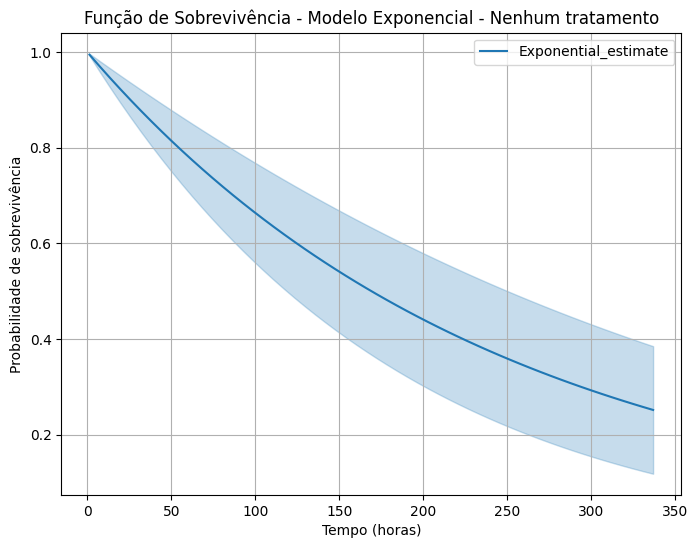

In [156]:
# Plotar a função de sobrevivência
plt.figure(figsize=(8, 6))
exp_fitter_a.plot_survival_function()
plt.title('Função de Sobrevivência - Modelo Exponencial - Nenhum tratamento')
plt.xlabel('Tempo (horas)')
plt.ylabel('Probabilidade de sobrevivência')
plt.grid()
plt.show()

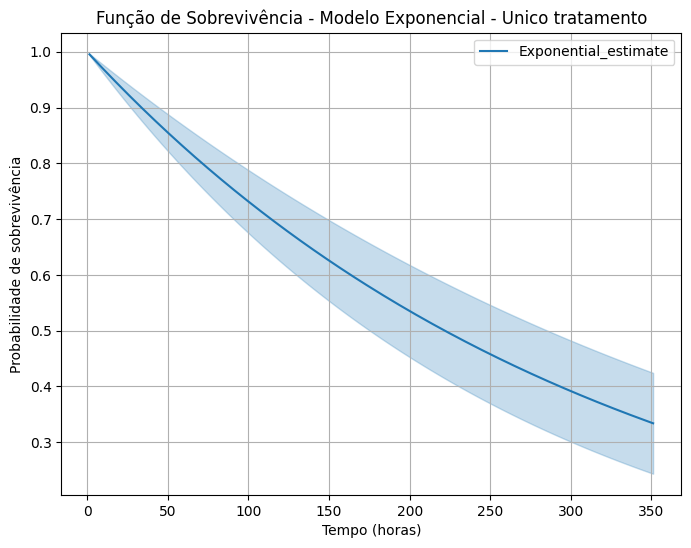

In [157]:
# Plotar a função de sobrevivência
plt.figure(figsize=(8, 6))
exp_fitter_b.plot_survival_function()
plt.title('Função de Sobrevivência - Modelo Exponencial - Unico tratamento')
plt.xlabel('Tempo (horas)')
plt.ylabel('Probabilidade de sobrevivência')
plt.grid()
plt.show()

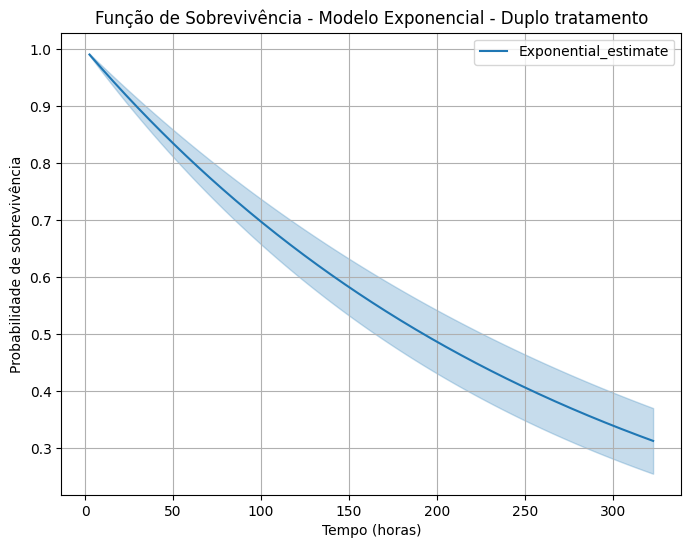

In [158]:
# Plotar a função de sobrevivência
plt.figure(figsize=(8, 6))
exp_fitter_c.plot_survival_function()
plt.title('Função de Sobrevivência - Modelo Exponencial - Duplo tratamento')
plt.xlabel('Tempo (horas)')
plt.ylabel('Probabilidade de sobrevivência')
plt.grid()
plt.show()

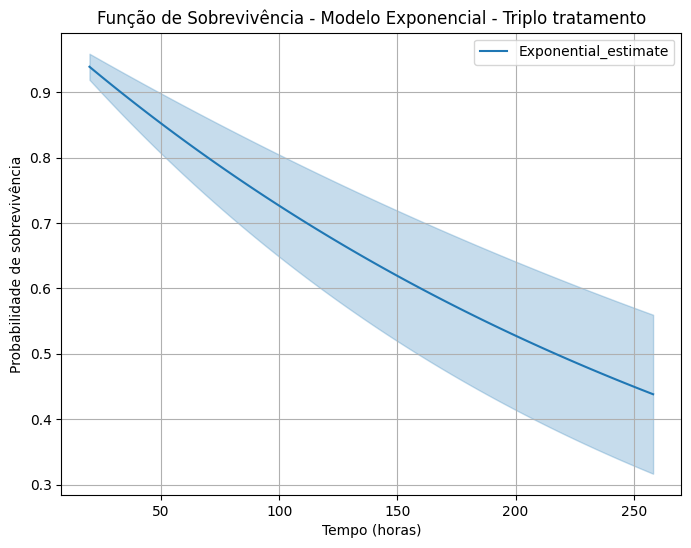

In [159]:
# Plotar a função de sobrevivência
plt.figure(figsize=(8, 6))
exp_fitter_d.plot_survival_function()
plt.title('Função de Sobrevivência - Modelo Exponencial - Triplo tratamento')
plt.xlabel('Tempo (horas)')
plt.ylabel('Probabilidade de sobrevivência')
plt.grid()
plt.show()

In [160]:
# Função de risco constante para o modelo exponencial unico tratamento
lambda_param = exp_fitter_a.lambda_  # Taxa de falha
print(f"\nFunção de risco (constante para modelo exponencial) - Nenhum tratamento: {lambda_param:.4f}")

# Função de risco constante para o modelo exponencial
lambda_param = exp_fitter_b.lambda_  # Taxa de falha
print(f"\nFunção de risco (constante para modelo exponencial) - unico tratamento: {lambda_param:.4f}")

# Função de risco constante para o modelo exponencial
lambda_param = exp_fitter_c.lambda_  # Taxa de falha
print(f"\nFunção de risco (constante para modelo exponencial) - Duplo tratamento: {lambda_param:.4f}")

# Função de risco constante para o modelo exponencial
lambda_param = exp_fitter_d.lambda_  # Taxa de falha
print(f"\nFunção de risco (constante para modelo exponencial) - Triplo tratamento: {lambda_param:.4f}")


Função de risco (constante para modelo exponencial) - Nenhum tratamento: 244.1730

Função de risco (constante para modelo exponencial) - unico tratamento: 319.9709

Função de risco (constante para modelo exponencial) - Duplo tratamento: 277.8791

Função de risco (constante para modelo exponencial) - Triplo tratamento: 312.7677


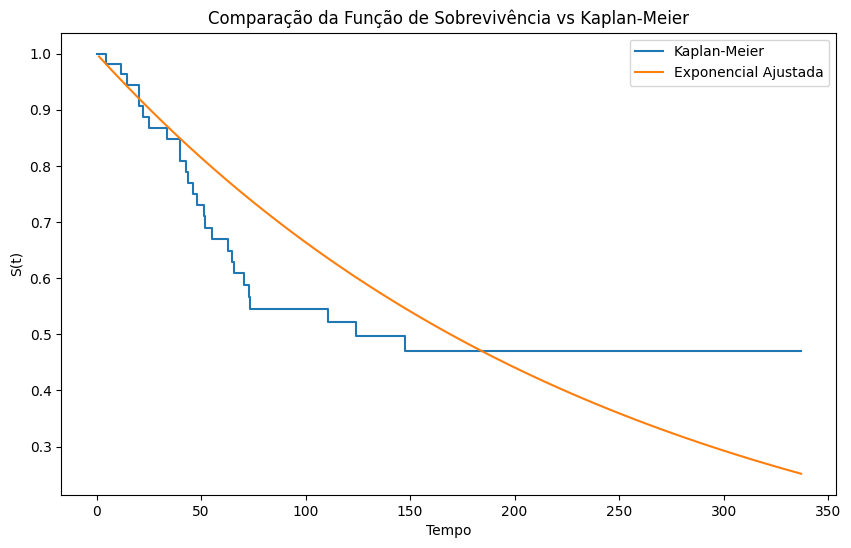

In [162]:
# Kaplan-Meier
kmf = KaplanMeierFitter()
kmf.fit(group_a['Overall Survival (Months)'], event_observed=group_a['event'])
# Gráfico de sobrevivência empírica e ajustada
plt.figure(figsize=(10, 6))
kmf.plot_survival_function(ci_show=False, label='Kaplan-Meier')
exp_fitter_a.plot_survival_function(ci_show=False, label='Exponencial Ajustada')
plt.title('Comparação da Função de Sobrevivência vs Kaplan-Meier')
plt.xlabel('Tempo')
plt.ylabel('S(t)')
plt.legend()
plt.show()

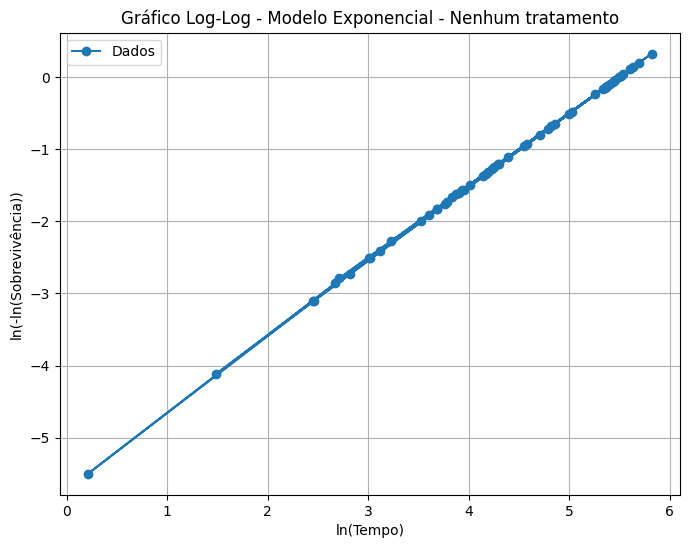

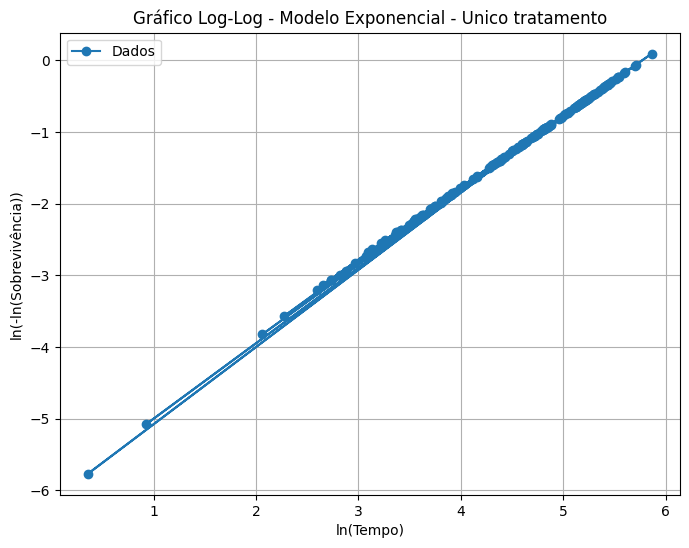

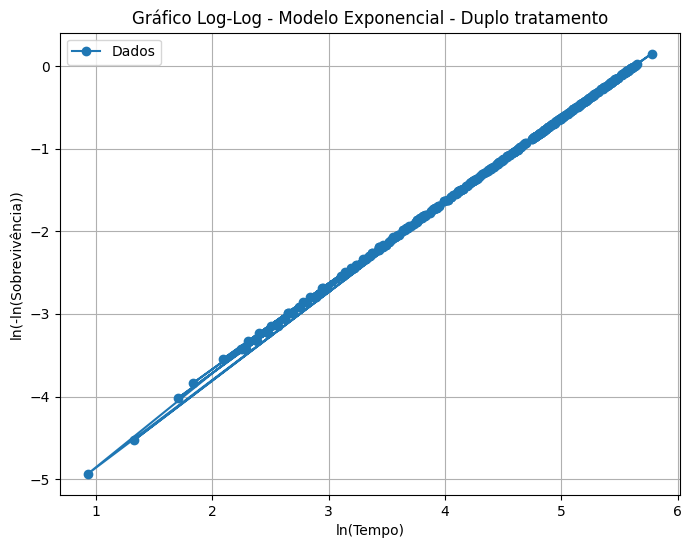

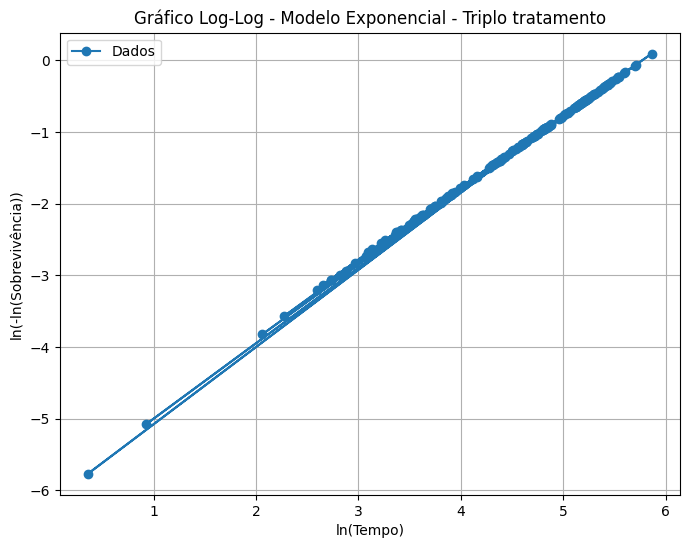

In [189]:
# Função de sobrevivência ajustada pelo modelo Exponencial
sobrevivencia = exp_fitter_a.survival_function_at_times(group_a['Overall Survival (Months)'].astype(int).tolist())

# Transformações para o gráfico log-log
log_tempo = np.log(group_a['Overall Survival (Months)'])
log_neg_log_sobrevivencia = np.log(-np.log(sobrevivencia))

# Plotar gráfico log-log
plt.figure(figsize=(8, 6))
plt.plot(log_tempo, log_neg_log_sobrevivencia, 'o-', label='Dados')
plt.title('Gráfico Log-Log - Modelo Exponencial - Nenhum tratamento')
plt.xlabel('ln(Tempo)')
plt.ylabel('ln(-ln(Sobrevivência))')
plt.grid()
plt.legend()
plt.show()

# Função de sobrevivência ajustada pelo modelo Exponencial
sobrevivencia = exp_fitter_b.survival_function_at_times(group_b['Overall Survival (Months)'].astype(int).tolist())

# Transformações para o gráfico log-log
log_tempo = np.log(group_b['Overall Survival (Months)'])
log_neg_log_sobrevivencia = np.log(-np.log(sobrevivencia))

# Plotar gráfico log-log
plt.figure(figsize=(8, 6))
plt.plot(log_tempo, log_neg_log_sobrevivencia, 'o-', label='Dados')
plt.title('Gráfico Log-Log - Modelo Exponencial - Unico tratamento')
plt.xlabel('ln(Tempo)')
plt.ylabel('ln(-ln(Sobrevivência))')
plt.grid()
plt.legend()
plt.show()

# Função de sobrevivência ajustada pelo modelo Exponencial
sobrevivencia = exp_fitter_c.survival_function_at_times(group_c['Overall Survival (Months)'].astype(int).tolist())

# Transformações para o gráfico log-log
log_tempo = np.log(group_c['Overall Survival (Months)'])
log_neg_log_sobrevivencia = np.log(-np.log(sobrevivencia))

# Plotar gráfico log-log
plt.figure(figsize=(8, 6))
plt.plot(log_tempo, log_neg_log_sobrevivencia, 'o-', label='Dados')
plt.title('Gráfico Log-Log - Modelo Exponencial - Duplo tratamento')
plt.xlabel('ln(Tempo)')
plt.ylabel('ln(-ln(Sobrevivência))')
plt.grid()
plt.legend()
plt.show()

# Função de sobrevivência ajustada pelo modelo Exponencial
sobrevivencia = exp_fitter_b.survival_function_at_times(group_b['Overall Survival (Months)'].astype(int).tolist())

# Transformações para o gráfico log-log
log_tempo = np.log(group_b['Overall Survival (Months)'])
log_neg_log_sobrevivencia = np.log(-np.log(sobrevivencia))

# Plotar gráfico log-log
plt.figure(figsize=(8, 6))
plt.plot(log_tempo, log_neg_log_sobrevivencia, 'o-', label='Dados')
plt.title('Gráfico Log-Log - Modelo Exponencial - Triplo tratamento')
plt.xlabel('ln(Tempo)')
plt.ylabel('ln(-ln(Sobrevivência))')
plt.grid()
plt.legend()
plt.show()


In [238]:
tempo_medio_sobrevivencia = 1 / exp_fitter_a.lambda_
print(f"Grupo Nenhum Tratamento")
print(f"Tempo médio de sobrevivência: {tempo_medio_sobrevivencia:.6f} meses")

tempo_medio_sobrevivencia = 1 / exp_fitter_b.lambda_
print(f"\nGrupo Unico Tratamento")
print(f"Tempo médio de sobrevivência: {tempo_medio_sobrevivencia:.6f} meses")

tempo_medio_sobrevivencia = 1 / exp_fitter_c.lambda_
print(f"\nGrupo Duplo Tratamento")
print(f"Tempo médio de sobrevivência: {tempo_medio_sobrevivencia:.6f} meses")

tempo_medio_sobrevivencia = 1 / exp_fitter_d.lambda_
print(f"\nGrupo Triplo Tratamento")
print(f"Tempo médio de sobrevivência: {tempo_medio_sobrevivencia:.6f} meses")

Grupo Nenhum Tratamento
Tempo médio de sobrevivência: 0.004095 meses

Grupo Nenhum Tratamento
Tempo médio de sobrevivência: 0.003125 meses

Grupo Nenhum Tratamento
Tempo médio de sobrevivência: 0.003599 meses

Grupo Nenhum Tratamento
Tempo médio de sobrevivência: 0.003197 meses


## Modelo Weibull

In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import WeibullFitter, KaplanMeierFitter

In [201]:
# Ajustar o modelo Weibull
weibull_fitter_a = WeibullFitter()
weibull_fitter_b = WeibullFitter()
weibull_fitter_c = WeibullFitter()
weibull_fitter_d = WeibullFitter()

weibull_fitter_a.fit(group_a['Overall Survival (Months)'], event_observed=group_a['event'])
weibull_fitter_b.fit(group_b['Overall Survival (Months)'], event_observed=group_b['event'])
weibull_fitter_c.fit(group_c['Overall Survival (Months)'], event_observed=group_c['event'])
weibull_fitter_d.fit(group_d['Overall Survival (Months)'], event_observed=group_d['event'])

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 100 total observations, 66 right-censored observations>

Exibir parametros Weibull

In [202]:
# Exibir os parâmetros do modelo
print("\nParâmetros do modelo Weibull - Nenhum tratamento:")
print(weibull_fitter_a.summary)

print("\nParâmetros do modelo Weibull - Unico tratamento:")
print(weibull_fitter_b.summary)

print("\nParâmetros do modelo Weibull - Duplo tratamento:")
print(weibull_fitter_c.summary)

print("\nParâmetros do modelo Weibull - Triplo tratamento:")
print(weibull_fitter_d.summary)


Parâmetros do modelo Weibull - Nenhum tratamento:
               coef   se(coef)  coef lower 95%  coef upper 95%  cmp to  \
lambda_  274.123399  73.082746      130.883848      417.362949     1.0   
rho_       0.804212   0.134551        0.540497        1.067927     1.0   

                z         p   -log2(p)  
lambda_  3.737180  0.000186  12.391669  
rho_    -1.455123  0.145635   2.779570  

Parâmetros do modelo Weibull - Unico tratamento:
               coef   se(coef)  coef lower 95%  coef upper 95%  cmp to  \
lambda_  290.552558  38.017920      216.038804      365.066313     1.0   
rho_       1.142926   0.123192        0.901474        1.384377     1.0   

                z             p   -log2(p)  
lambda_  7.616212  2.612276e-14  45.121686  
rho_     1.160190  2.459716e-01   2.023436  

Parâmetros do modelo Weibull - Duplo tratamento:
               coef   se(coef)  coef lower 95%  coef upper 95%  cmp to  \
lambda_  293.921529  29.918201      235.282933      352.560126     1.0 

###Estimando a Função de Sobrevivência S(t) pelo Método Weibull


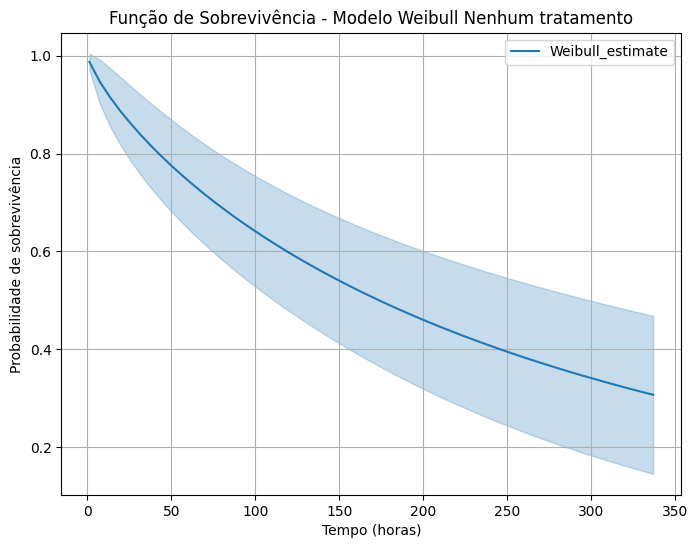

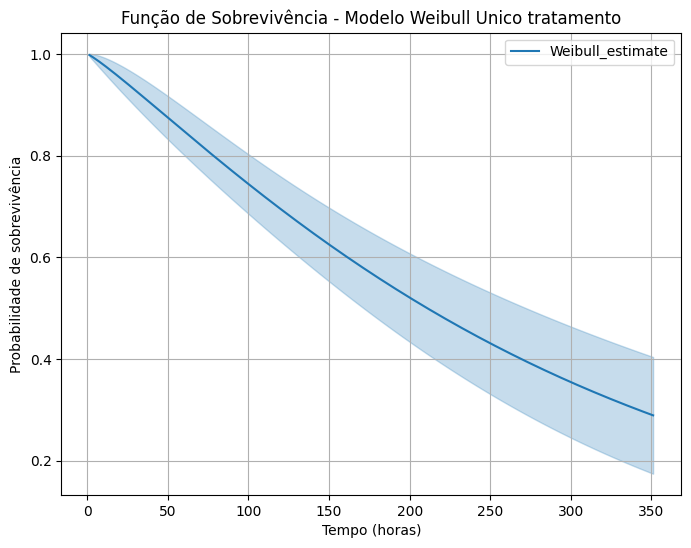

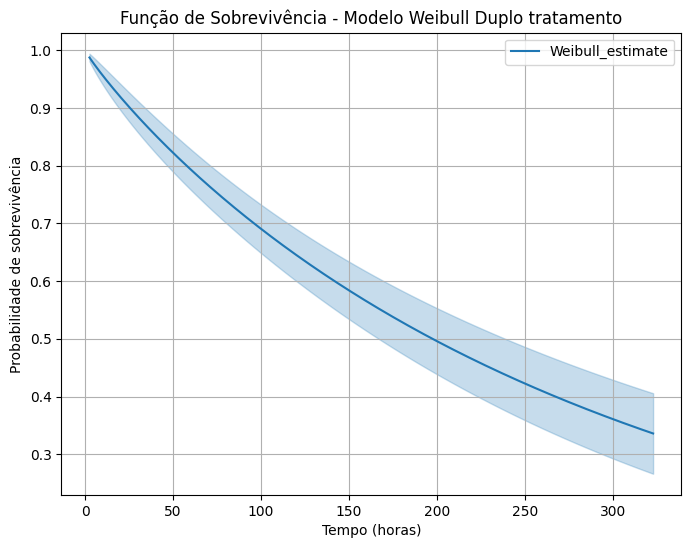

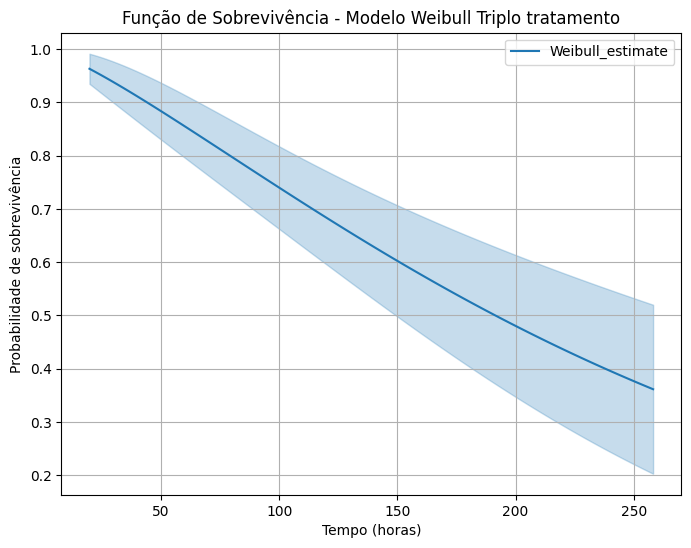

In [203]:
# Plotar a função de sobrevivência
plt.figure(figsize=(8, 6))
weibull_fitter_a.plot_survival_function()
plt.title('Função de Sobrevivência - Modelo Weibull Nenhum tratamento')
plt.xlabel('Tempo (horas)')
plt.ylabel('Probabilidade de sobrevivência')
plt.grid()
plt.show()

# Plotar a função de sobrevivência
plt.figure(figsize=(8, 6))
weibull_fitter_b.plot_survival_function()
plt.title('Função de Sobrevivência - Modelo Weibull Unico tratamento')
plt.xlabel('Tempo (horas)')
plt.ylabel('Probabilidade de sobrevivência')
plt.grid()
plt.show()

# Plotar a função de sobrevivência
plt.figure(figsize=(8, 6))
weibull_fitter_c.plot_survival_function()
plt.title('Função de Sobrevivência - Modelo Weibull Duplo tratamento')
plt.xlabel('Tempo (horas)')
plt.ylabel('Probabilidade de sobrevivência')
plt.grid()
plt.show()

# Plotar a função de sobrevivência
plt.figure(figsize=(8, 6))
weibull_fitter_d.plot_survival_function()
plt.title('Função de Sobrevivência - Modelo Weibull Triplo tratamento')
plt.xlabel('Tempo (horas)')
plt.ylabel('Probabilidade de sobrevivência')
plt.grid()
plt.show()

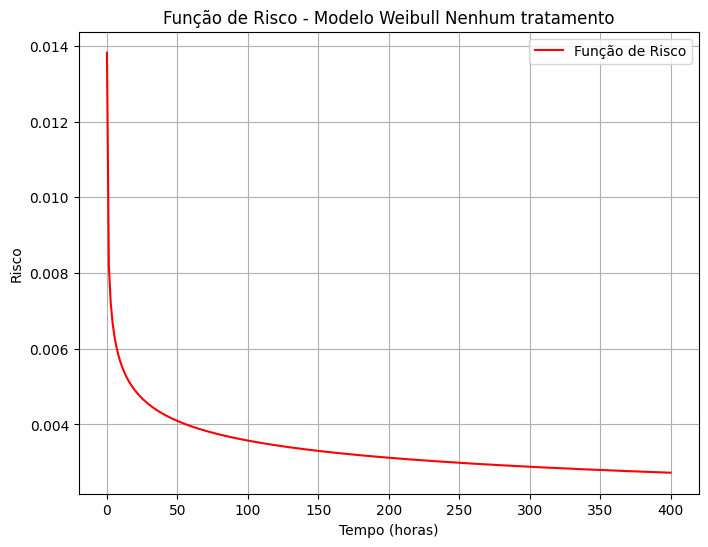

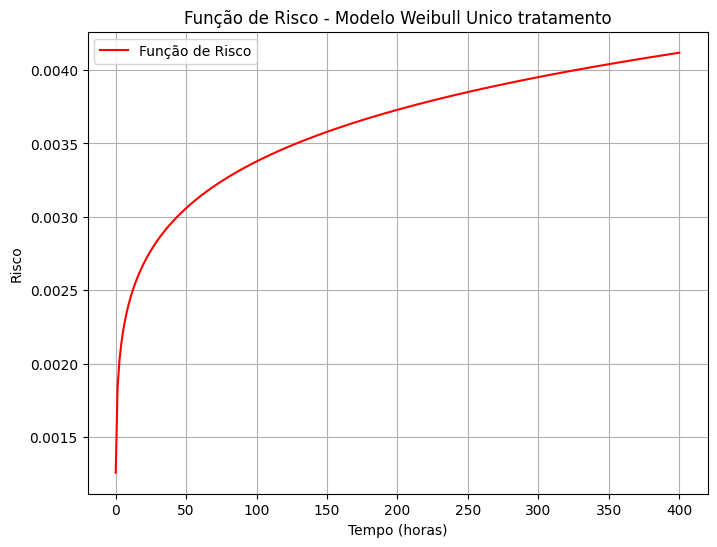

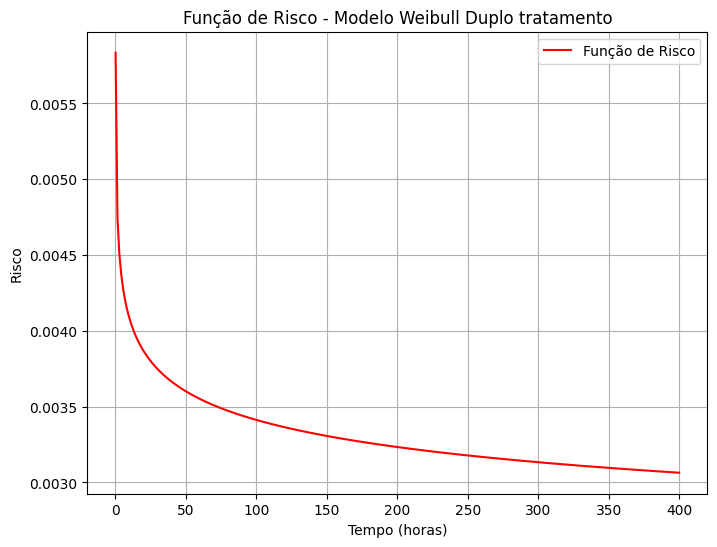

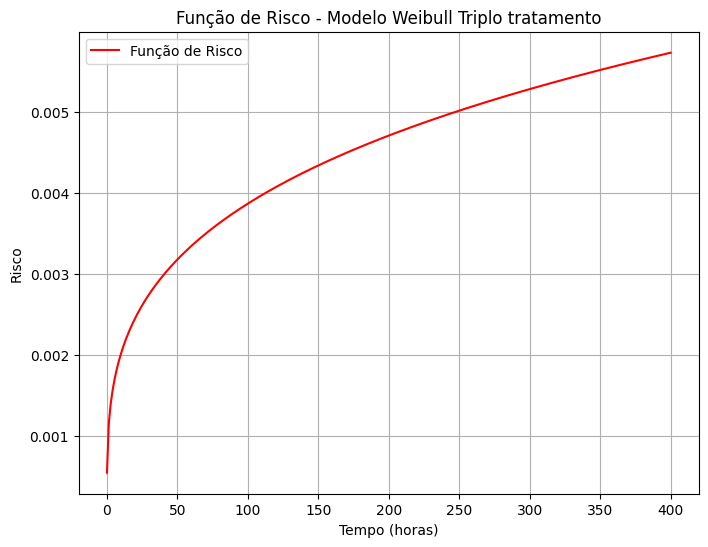

In [211]:
# Calcular a função de risco
tempos_plot = np.linspace(0.1, 400, 300)  # Evitar divisão por zero
risco = weibull_fitter_a.hazard_at_times(tempos_plot)

plt.figure(figsize=(8, 6))
plt.plot(tempos_plot, risco, label='Função de Risco', color='red')
plt.title('Função de Risco - Modelo Weibull Nenhum tratamento')
plt.xlabel('Tempo (horas)')
plt.ylabel('Risco')
plt.grid()
plt.legend()
plt.show()

tempos_plot = np.linspace(0.1, 400, 300)  # Evitar divisão por zero
risco = weibull_fitter_b.hazard_at_times(tempos_plot)
# Plotar a função de risco
plt.figure(figsize=(8, 6))
plt.plot(tempos_plot, risco, label='Função de Risco', color='red')
plt.title('Função de Risco - Modelo Weibull Unico tratamento')
plt.xlabel('Tempo (horas)')
plt.ylabel('Risco')
plt.grid()
plt.legend()
plt.show()

tempos_plot = np.linspace(0.1, 400, 300)  # Evitar divisão por zero
risco = weibull_fitter_c.hazard_at_times(tempos_plot)
# Plotar a função de risco
plt.figure(figsize=(8, 6))
plt.plot(tempos_plot, risco, label='Função de Risco', color='red')
plt.title('Função de Risco - Modelo Weibull Duplo tratamento')
plt.xlabel('Tempo (horas)')
plt.ylabel('Risco')
plt.grid()
plt.legend()
plt.show()

tempos_plot = np.linspace(0.1, 400, 300)  # Evitar divisão por zero
risco = weibull_fitter_d.hazard_at_times(tempos_plot)
# Plotar a função de risco
plt.figure(figsize=(8, 6))
plt.plot(tempos_plot, risco, label='Função de Risco', color='red')
plt.title('Função de Risco - Modelo Weibull Triplo tratamento')
plt.xlabel('Tempo (horas)')
plt.ylabel('Risco')
plt.grid()
plt.legend()
plt.show()

In [208]:
# Tempo médio de sobrevivência (Weibull não possui fórmula analítica direta, mas pode ser estimado numericamente)
def tempo_medio_weibull(a, b):
    from scipy.special import gamma
    return b * gamma(1 + 1/a)

print("Grupo Nenhum tratamento")
shape = weibull_fitter_a.rho_  # Forma (shape parameter)
scale = weibull_fitter_a.lambda_  # Escala (scale parameter)

tempo_medio_sobrevivencia = tempo_medio_weibull(shape, scale)
print(f"Tempo médio de sobrevivência: {tempo_medio_sobrevivencia:.2f} horas")

print("\nGrupo Unico tratamento")
shape = weibull_fitter_b.rho_  # Forma (shape parameter)
scale = weibull_fitter_b.lambda_  # Escala (scale parameter)

tempo_medio_sobrevivencia = tempo_medio_weibull(shape, scale)
print(f"Tempo médio de sobrevivência: {tempo_medio_sobrevivencia:.2f} horas")

print("\nGrupo Duplo tratamento")
shape = weibull_fitter_c.rho_  # Forma (shape parameter)
scale = weibull_fitter_c.lambda_  # Escala (scale parameter)

tempo_medio_sobrevivencia = tempo_medio_weibull(shape, scale)
print(f"Tempo médio de sobrevivência: {tempo_medio_sobrevivencia:.2f} horas")

print("\nGrupo Triplo tratamento")
shape = weibull_fitter_d.rho_  # Forma (shape parameter)
scale = weibull_fitter_d.lambda_  # Escala (scale parameter)

tempo_medio_sobrevivencia = tempo_medio_weibull(shape, scale)
print(f"Tempo médio de sobrevivência: {tempo_medio_sobrevivencia:.2f} horas")

Grupo Nenhum tratamento
Tempo médio de sobrevivência: 309.42 horas

Grupo Unico tratamento
Tempo médio de sobrevivência: 277.02 horas

Grupo Duplo tratamento
Tempo médio de sobrevivência: 305.26 horas

Grupo Triplo tratamento
Tempo médio de sobrevivência: 235.82 horas


### Interpretação gráfica
1. A curva da função de sobrevivência mostra a probabilidade de o equipamento sobreviver até um determinado tempo.
2. A função de risco da distribuição Weibull pode aumentar, diminuir ou ser constante, dependendo do parâmetro de forma (shape).

Podemos perceber que para um unico tratamento e um triplo tratamento a chance de risco é crescente. Ou seja, existe uma maior chance da pessoa morrer de cnacer quanto mais o tempo passa.

##Gráfico Comparação da Função de Sobrevivência vs Kaplan-Meier


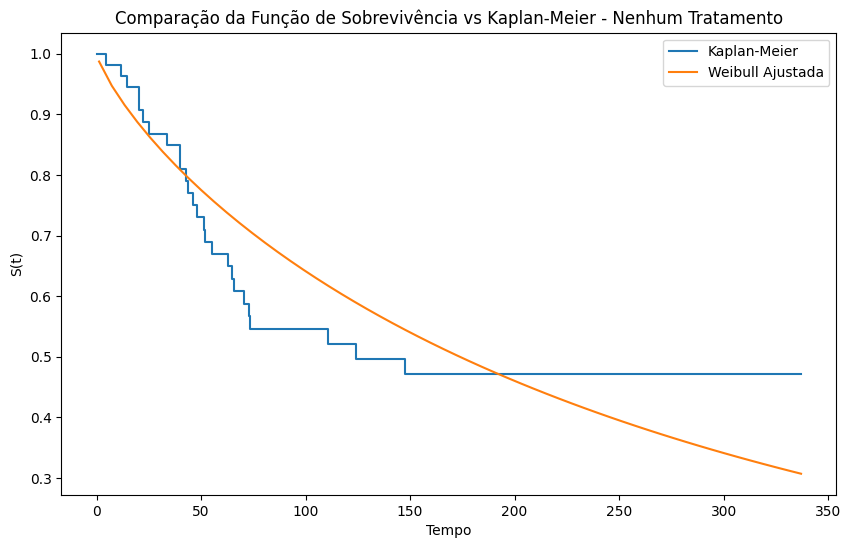

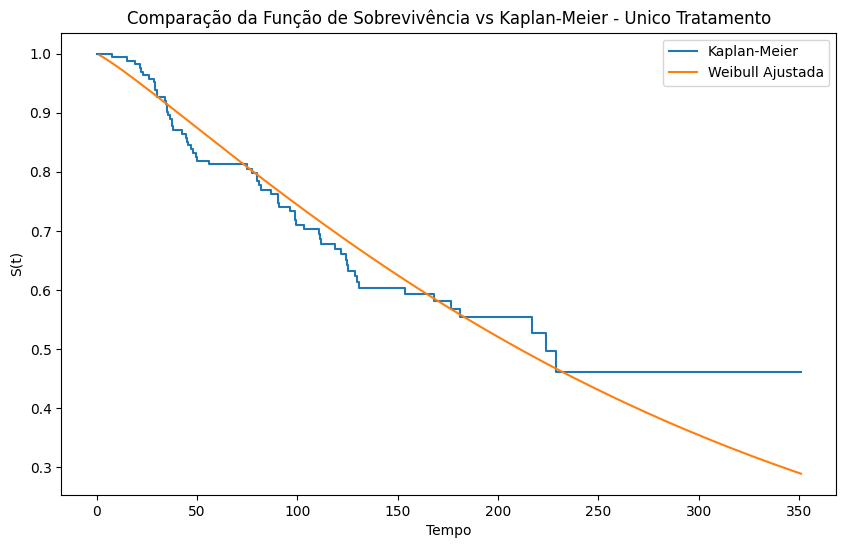

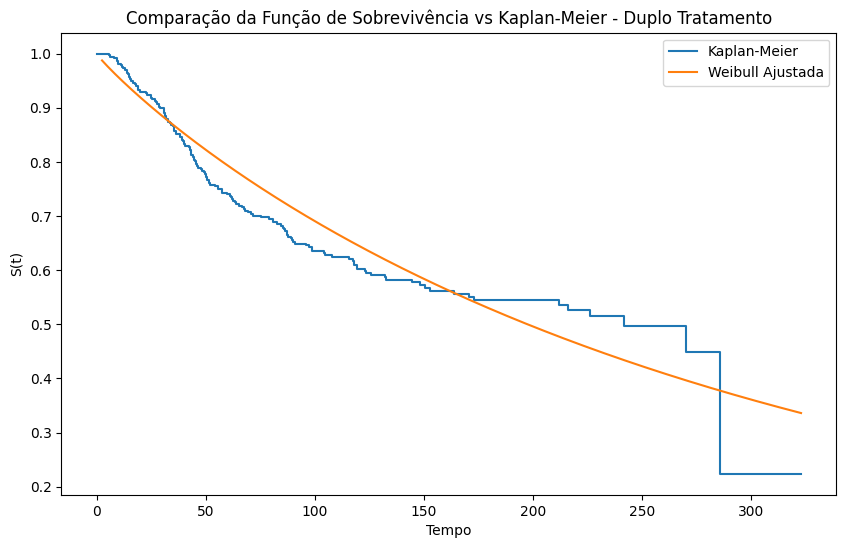

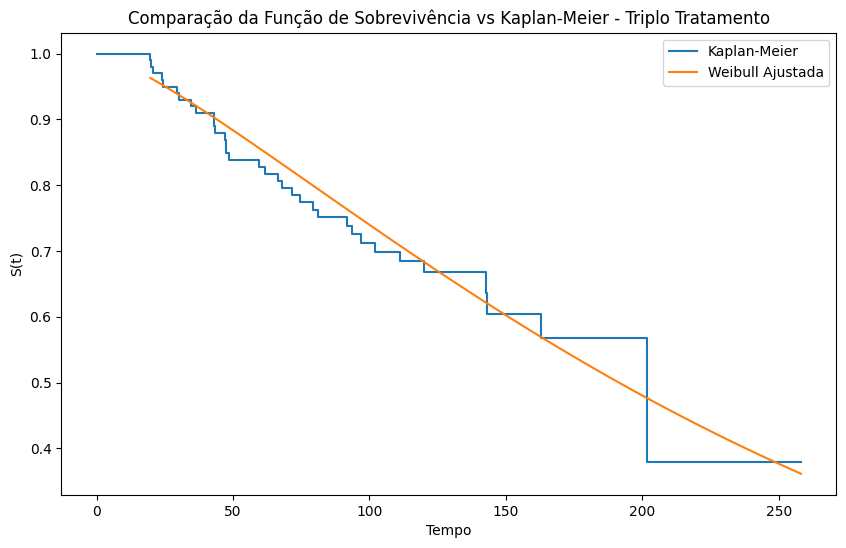

In [214]:
# Kaplan-Meier
kmf = KaplanMeierFitter()
kmf.fit(group_a['Overall Survival (Months)'], event_observed=group_a['event'])
# Gráfico de sobrevivência empírica e ajustada
plt.figure(figsize=(10, 6))
kmf.plot_survival_function(ci_show=False, label='Kaplan-Meier')
weibull_fitter_a.plot_survival_function(ci_show=False, label='Weibull Ajustada')
plt.title('Comparação da Função de Sobrevivência vs Kaplan-Meier - Nenhum Tratamento')
plt.xlabel('Tempo')
plt.ylabel('S(t)')
plt.legend()
plt.show()

# Kaplan-Meier
kmf = KaplanMeierFitter()
kmf.fit(group_b['Overall Survival (Months)'], event_observed=group_b['event'])
# Gráfico de sobrevivência empírica e ajustada
plt.figure(figsize=(10, 6))
kmf.plot_survival_function(ci_show=False, label='Kaplan-Meier')
weibull_fitter_b.plot_survival_function(ci_show=False, label='Weibull Ajustada')
plt.title('Comparação da Função de Sobrevivência vs Kaplan-Meier - Unico Tratamento')
plt.xlabel('Tempo')
plt.ylabel('S(t)')
plt.legend()
plt.show()

# Kaplan-Meier
kmf = KaplanMeierFitter()
kmf.fit(group_c['Overall Survival (Months)'], event_observed=group_c['event'])
# Gráfico de sobrevivência empírica e ajustada
plt.figure(figsize=(10, 6))
kmf.plot_survival_function(ci_show=False, label='Kaplan-Meier')
weibull_fitter_c.plot_survival_function(ci_show=False, label='Weibull Ajustada')
plt.title('Comparação da Função de Sobrevivência vs Kaplan-Meier - Duplo Tratamento')
plt.xlabel('Tempo')
plt.ylabel('S(t)')
plt.legend()
plt.show()

# Kaplan-Meier
kmf = KaplanMeierFitter()
kmf.fit(group_d['Overall Survival (Months)'], event_observed=group_d['event'])
# Gráfico de sobrevivência empírica e ajustada
plt.figure(figsize=(10, 6))
kmf.plot_survival_function(ci_show=False, label='Kaplan-Meier')
weibull_fitter_d.plot_survival_function(ci_show=False, label='Weibull Ajustada')
plt.title('Comparação da Função de Sobrevivência vs Kaplan-Meier - Triplo Tratamento')
plt.xlabel('Tempo')
plt.ylabel('S(t)')
plt.legend()
plt.show()

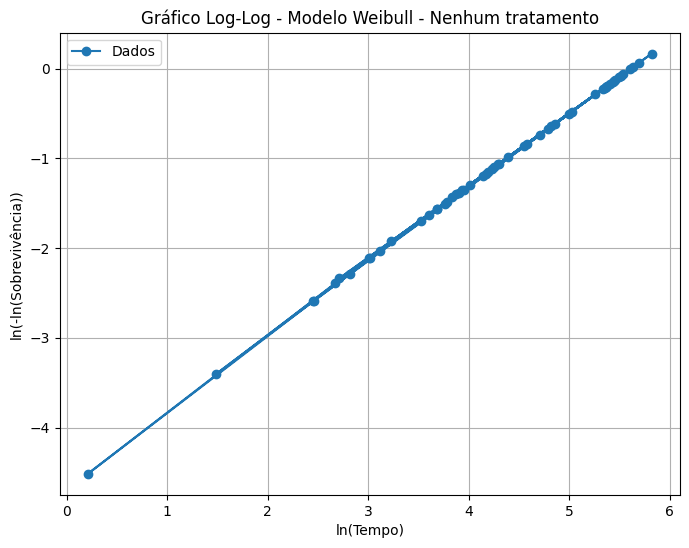

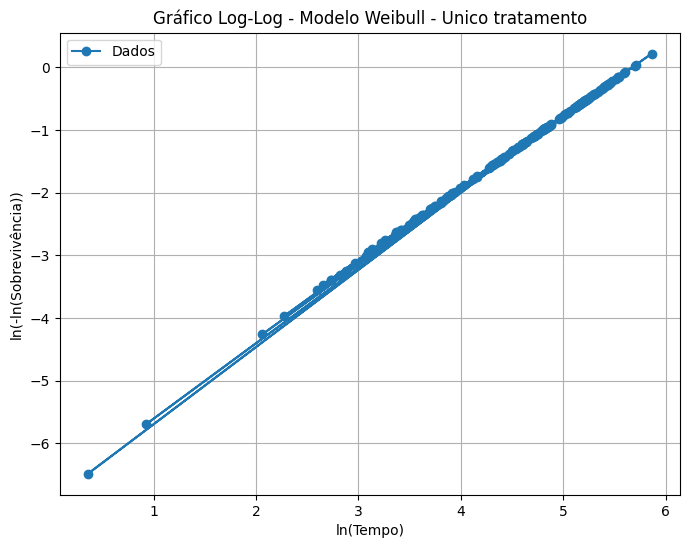

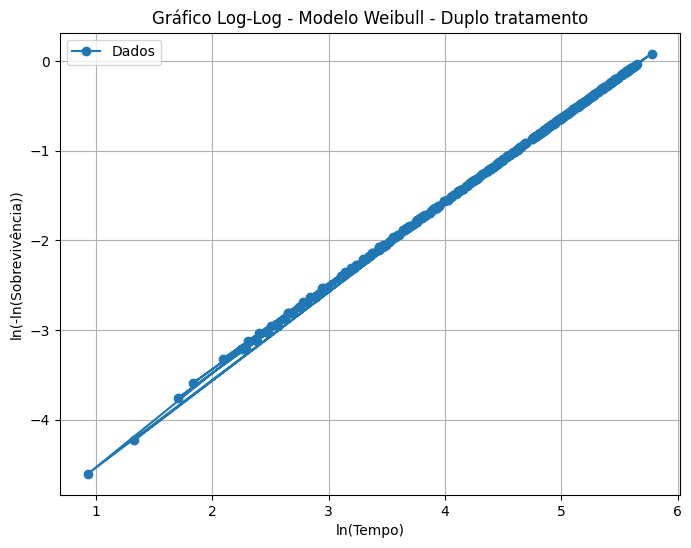

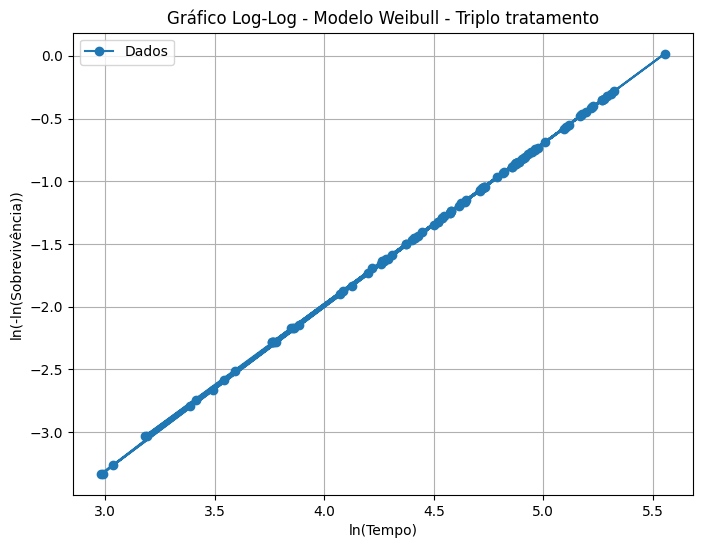

In [233]:
# Função de sobrevivência ajustada pelo modelo Weibull
sobrevivencia = weibull_fitter_a.survival_function_at_times(group_a['Overall Survival (Months)'].astype(int).tolist())

# Transformações para o gráfico log-log
log_tempo = np.log(group_a['Overall Survival (Months)'])
log_neg_log_sobrevivencia = np.log(-np.log(sobrevivencia))

# Plotar gráfico log-log
plt.figure(figsize=(8, 6))
plt.plot(log_tempo, log_neg_log_sobrevivencia, 'o-', label='Dados')
plt.title('Gráfico Log-Log - Modelo Weibull - Nenhum tratamento')
plt.xlabel('ln(Tempo)')
plt.ylabel('ln(-ln(Sobrevivência))')
plt.grid()
plt.legend()
plt.show()

# Função de sobrevivência ajustada pelo modelo Weibull
sobrevivencia = weibull_fitter_b.survival_function_at_times(group_b['Overall Survival (Months)'].astype(int).tolist())

# Transformações para o gráfico log-log
log_tempo = np.log(group_b['Overall Survival (Months)'])
log_neg_log_sobrevivencia = np.log(-np.log(sobrevivencia))
# Plotar gráfico log-log
plt.figure(figsize=(8, 6))
plt.plot(log_tempo, log_neg_log_sobrevivencia, 'o-', label='Dados')
plt.title('Gráfico Log-Log - Modelo Weibull - Unico tratamento')
plt.xlabel('ln(Tempo)')
plt.ylabel('ln(-ln(Sobrevivência))')
plt.grid()
plt.legend()
plt.show()

# Função de sobrevivência ajustada pelo modelo Weibull
sobrevivencia = weibull_fitter_c.survival_function_at_times(group_c['Overall Survival (Months)'].astype(int).tolist())

# Transformações para o gráfico log-log
log_tempo = np.log(group_c['Overall Survival (Months)'])
log_neg_log_sobrevivencia = np.log(-np.log(sobrevivencia))
# Plotar gráfico log-log
plt.figure(figsize=(8, 6))
plt.plot(log_tempo, log_neg_log_sobrevivencia, 'o-', label='Dados')
plt.title('Gráfico Log-Log - Modelo Weibull - Duplo tratamento')
plt.xlabel('ln(Tempo)')
plt.ylabel('ln(-ln(Sobrevivência))')
plt.grid()
plt.legend()
plt.show()

# Função de sobrevivência ajustada pelo modelo Weibull
sobrevivencia = weibull_fitter_d.survival_function_at_times(group_d['Overall Survival (Months)'].astype(int).tolist())

# Transformações para o gráfico log-log
log_tempo = np.log(group_d['Overall Survival (Months)'])
log_neg_log_sobrevivencia = np.log(-np.log(sobrevivencia))
# Plotar gráfico log-log
plt.figure(figsize=(8, 6))
plt.plot(log_tempo, log_neg_log_sobrevivencia, 'o-', label='Dados')
plt.title('Gráfico Log-Log - Modelo Weibull - Triplo tratamento')
plt.xlabel('ln(Tempo)')
plt.ylabel('ln(-ln(Sobrevivência))')
plt.grid()
plt.legend()
plt.show()

##  Modelo Log-Normal

In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import probplot
from lifelines import LogNormalFitter

In [216]:
# Ajustar o modelo Log-Normal
lognormal_fitter_a = LogNormalFitter()
lognormal_fitter_b = LogNormalFitter()
lognormal_fitter_c = LogNormalFitter()
lognormal_fitter_d = LogNormalFitter()

lognormal_fitter_a.fit(group_a['Overall Survival (Months)'], event_observed=group_a['event'])
lognormal_fitter_b.fit(group_b['Overall Survival (Months)'], event_observed=group_b['event'])
lognormal_fitter_c.fit(group_c['Overall Survival (Months)'], event_observed=group_c['event'])
lognormal_fitter_d.fit(group_d['Overall Survival (Months)'], event_observed=group_d['event'])


<lifelines.LogNormalFitter:"LogNormal_estimate", fitted with 100 total observations, 66 right-censored observations>

###Parâmetros no Método Log-Normal

In [217]:
# Exibir os parâmetros do modelo
print("\nParâmetros do modelo Log-Normal - Nenhum tratamento:")
print(lognormal_fitter_a.summary)

print("\nParâmetros do modelo Log-Normal - Unico tratamento:")
print(lognormal_fitter_b.summary)

print("\nParâmetros do modelo Log-Normal - Duplo tratamento:")
print(lognormal_fitter_c.summary)

print("\nParâmetros do modelo Log-Normal - Triplo tratamento:")
print(lognormal_fitter_d.summary)


Parâmetros do modelo Log-Normal - Nenhum tratamento:
            coef  se(coef)  coef lower 95%  coef upper 95%  cmp to          z  \
mu_     5.081501  0.274584        4.543325        5.619676     0.0  18.506153   
sigma_  1.608416  0.246391        1.125498        2.091334     1.0   2.469308   

                   p    -log2(p)  
mu_     1.841966e-76  251.585289  
sigma_  1.353747e-02    6.206898  

Parâmetros do modelo Log-Normal - Unico tratamento:
            coef  se(coef)  coef lower 95%  coef upper 95%  cmp to          z  \
mu_     5.370150  0.144627        5.086686        5.653614     0.0  37.131031   
sigma_  1.287654  0.125702        1.041281        1.534026     1.0   2.288370   

                    p     -log2(p)  
mu_     8.872928e-302  1000.072874  
sigma_   2.211597e-02     5.498768  

Parâmetros do modelo Log-Normal - Duplo tratamento:
            coef  se(coef)  coef lower 95%  coef upper 95%  cmp to          z  \
mu_     5.278636  0.109229        5.064550        5.492

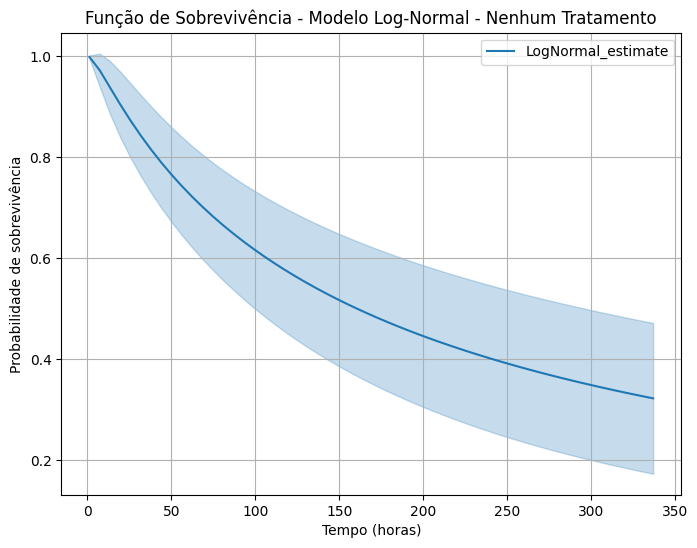

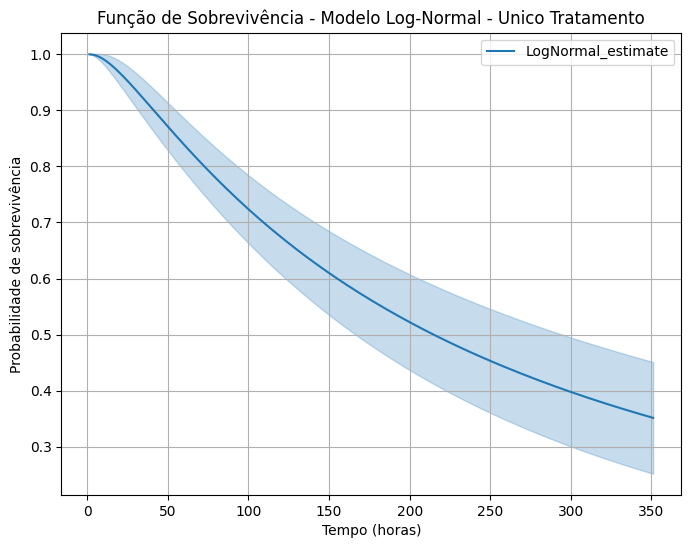

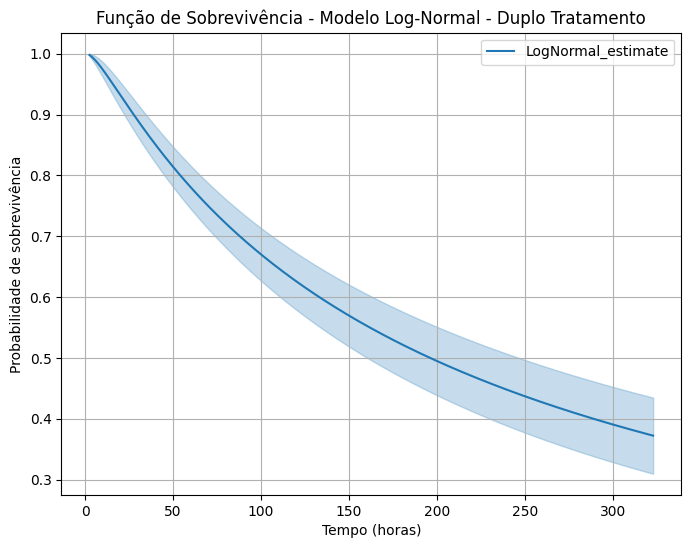

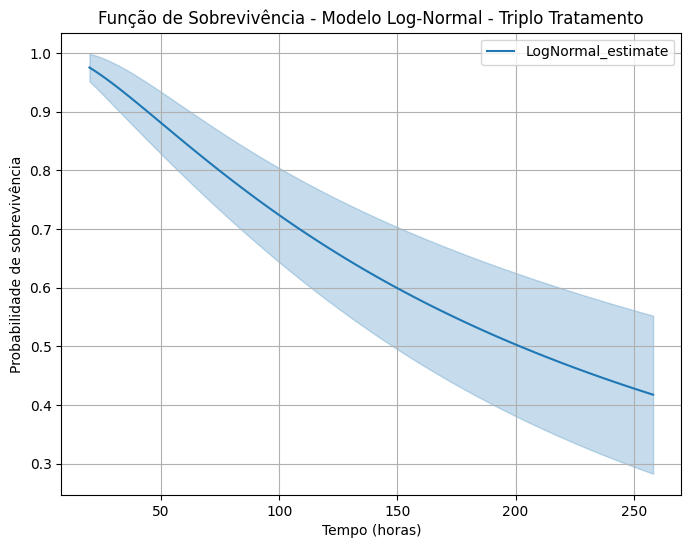

In [218]:
# Plotar a função de sobrevivência
plt.figure(figsize=(8, 6))
lognormal_fitter_a.plot_survival_function()
plt.title('Função de Sobrevivência - Modelo Log-Normal - Nenhum Tratamento')
plt.xlabel('Tempo (horas)')
plt.ylabel('Probabilidade de sobrevivência')
plt.grid()
plt.show()

# Plotar a função de sobrevivência
plt.figure(figsize=(8, 6))
lognormal_fitter_b.plot_survival_function()
plt.title('Função de Sobrevivência - Modelo Log-Normal - Unico Tratamento')
plt.xlabel('Tempo (horas)')
plt.ylabel('Probabilidade de sobrevivência')
plt.grid()
plt.show()

# Plotar a função de sobrevivência
plt.figure(figsize=(8, 6))
lognormal_fitter_c.plot_survival_function()
plt.title('Função de Sobrevivência - Modelo Log-Normal - Duplo Tratamento')
plt.xlabel('Tempo (horas)')
plt.ylabel('Probabilidade de sobrevivência')
plt.grid()
plt.show()

# Plotar a função de sobrevivência
plt.figure(figsize=(8, 6))
lognormal_fitter_d.plot_survival_function()
plt.title('Função de Sobrevivência - Modelo Log-Normal - Triplo Tratamento')
plt.xlabel('Tempo (horas)')
plt.ylabel('Probabilidade de sobrevivência')
plt.grid()
plt.show()

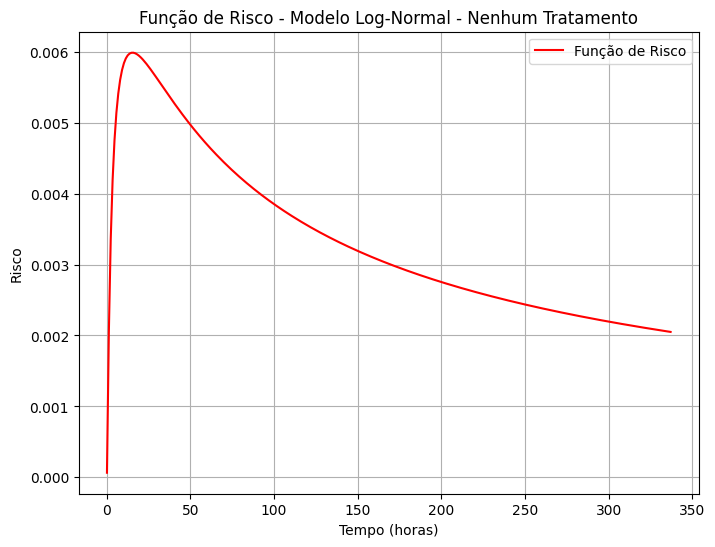

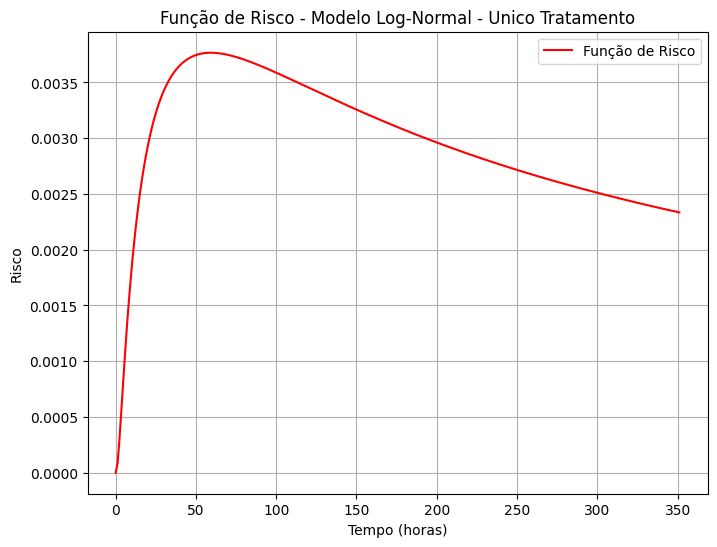

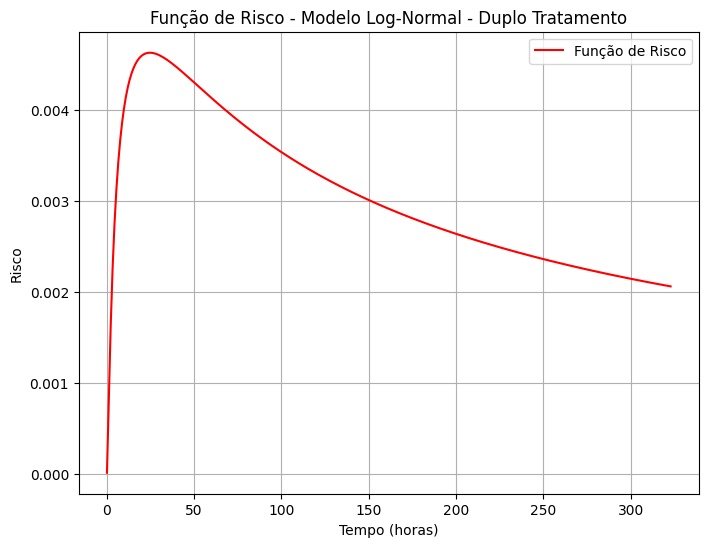

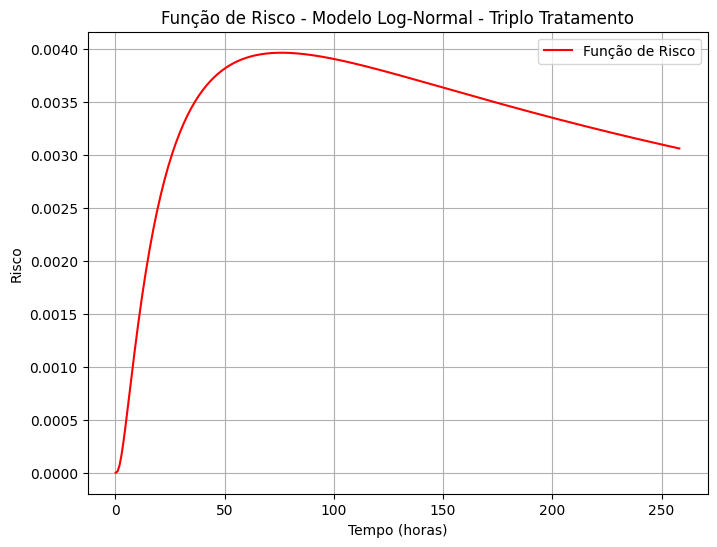

In [234]:
# Calcular a função de risco
tempos_plot = np.linspace(0.1, max(group_a['Overall Survival (Months)']), 300)  # Evitar divisão por zero
risco = lognormal_fitter_a.hazard_at_times(tempos_plot)

# Plotar a função de risco
plt.figure(figsize=(8, 6))
plt.plot(tempos_plot, risco, label='Função de Risco', color='red')
plt.title('Função de Risco - Modelo Log-Normal - Nenhum Tratamento')
plt.xlabel('Tempo (horas)')
plt.ylabel('Risco')
plt.grid()
plt.legend()
plt.show()

# Calcular a função de risco
tempos_plot = np.linspace(0.1, max(group_b['Overall Survival (Months)']), 300)  # Evitar divisão por zero
risco = lognormal_fitter_b.hazard_at_times(tempos_plot)

# Plotar a função de risco
plt.figure(figsize=(8, 6))
plt.plot(tempos_plot, risco, label='Função de Risco', color='red')
plt.title('Função de Risco - Modelo Log-Normal - Unico Tratamento')
plt.xlabel('Tempo (horas)')
plt.ylabel('Risco')
plt.grid()
plt.legend()
plt.show()

# Calcular a função de risco
tempos_plot = np.linspace(0.1, max(group_c['Overall Survival (Months)']), 300)  # Evitar divisão por zero
risco = lognormal_fitter_c.hazard_at_times(tempos_plot)

# Plotar a função de risco
plt.figure(figsize=(8, 6))
plt.plot(tempos_plot, risco, label='Função de Risco', color='red')
plt.title('Função de Risco - Modelo Log-Normal - Duplo Tratamento')
plt.xlabel('Tempo (horas)')
plt.ylabel('Risco')
plt.grid()
plt.legend()
plt.show()

# Calcular a função de risco
tempos_plot = np.linspace(0.1, max(group_d['Overall Survival (Months)']), 300)  # Evitar divisão por zero
risco = lognormal_fitter_d.hazard_at_times(tempos_plot)

# Plotar a função de risco
plt.figure(figsize=(8, 6))
plt.plot(tempos_plot, risco, label='Função de Risco', color='red')
plt.title('Função de Risco - Modelo Log-Normal - Triplo Tratamento')
plt.xlabel('Tempo (horas)')
plt.ylabel('Risco')
plt.grid()
plt.legend()
plt.show()

###Tempo Médio Esperado de Sobrevivência

In [235]:
# Tempo médio de sobrevivência (estimado numericamente)
def tempo_medio_lognormal(mu, sigma):
    from scipy.stats import lognorm
    mean = lognorm.mean(s=sigma, scale=np.exp(mu))
    return mean

mu = lognormal_fitter_a.mu_  # Parâmetro de localização (mu)
sigma = lognormal_fitter_a.sigma_  # Parâmetro de escala (sigma)

tempo_medio_sobrevivencia = tempo_medio_lognormal(mu, sigma)
print(f"\nGrupo Nenhum Tratamento")
print(f"Tempo médio de sobrevivência: {tempo_medio_sobrevivencia:.2f} meses")

mu = lognormal_fitter_b.mu_  # Parâmetro de localização (mu)
sigma = lognormal_fitter_b.sigma_  # Parâmetro de escala (sigma)

tempo_medio_sobrevivencia = tempo_medio_lognormal(mu, sigma)
print(f"\nGrupo Unico Tratamento")
print(f"Tempo médio de sobrevivência: {tempo_medio_sobrevivencia:.2f} meses")

mu = lognormal_fitter_c.mu_  # Parâmetro de localização (mu)
sigma = lognormal_fitter_c.sigma_  # Parâmetro de escala (sigma)

tempo_medio_sobrevivencia = tempo_medio_lognormal(mu, sigma)
print(f"\nGrupo Duplo Tratamento")
print(f"Tempo médio de sobrevivência: {tempo_medio_sobrevivencia:.2f} meses")

mu = lognormal_fitter_d.mu_  # Parâmetro de localização (mu)
sigma = lognormal_fitter_d.sigma_  # Parâmetro de escala (sigma)

tempo_medio_sobrevivencia = tempo_medio_lognormal(mu, sigma)
print(f"\nGrupo Triplo Tratamento")
print(f"Tempo médio de sobrevivência: {tempo_medio_sobrevivencia:.2f} meses")


Grupo Nenhum Tratamento
Tempo médio de sobrevivência: 586.99 meses

Grupo Unico Tratamento
Tempo médio de sobrevivência: 492.34 meses

Grupo Duplo Tratamento
Tempo médio de sobrevivência: 631.54 meses

Grupo Triplo Tratamento
Tempo médio de sobrevivência: 406.18 meses


###Gráfico Q-Qplot para verificar a adequação do modelo

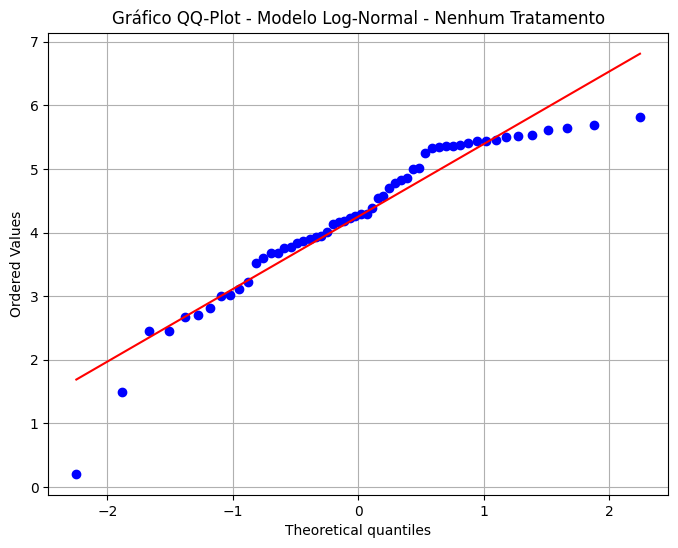

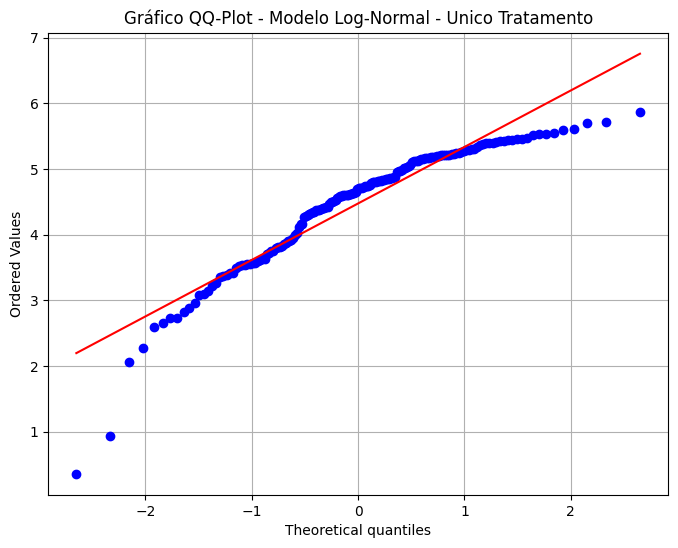

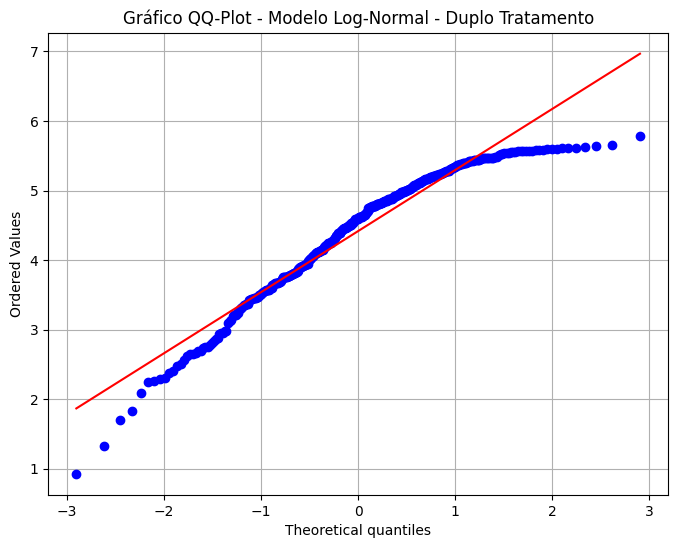

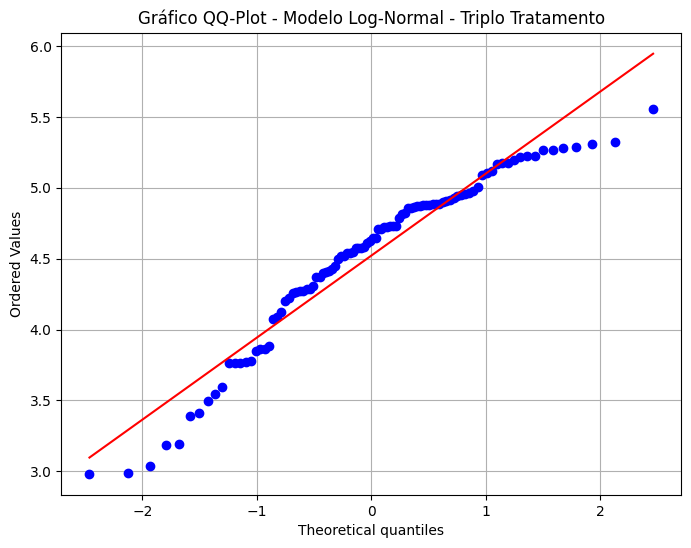

In [230]:
# Gráfico QQ-Plot para verificar ajuste ao modelo Log-Normal
log_tempos = np.log(group_a['Overall Survival (Months)'])  # Log-transformação dos tempos
plt.figure(figsize=(8, 6))
probplot(log_tempos, dist="norm", plot=plt)
plt.title("Gráfico QQ-Plot - Modelo Log-Normal - Nenhum Tratamento")
plt.grid()
plt.show()

# Gráfico QQ-Plot para verificar ajuste ao modelo Log-Normal
log_tempos = np.log(group_b['Overall Survival (Months)'])  # Log-transformação dos tempos
plt.figure(figsize=(8, 6))
probplot(log_tempos, dist="norm", plot=plt)
plt.title("Gráfico QQ-Plot - Modelo Log-Normal - Unico Tratamento")
plt.grid()
plt.show()

# Gráfico QQ-Plot para verificar ajuste ao modelo Log-Normal
log_tempos = np.log(group_c['Overall Survival (Months)'])  # Log-transformação dos tempos
plt.figure(figsize=(8, 6))
probplot(log_tempos, dist="norm", plot=plt)
plt.title("Gráfico QQ-Plot - Modelo Log-Normal - Duplo Tratamento")
plt.grid()
plt.show()

# Gráfico QQ-Plot para verificar ajuste ao modelo Log-Normal
log_tempos = np.log(group_d['Overall Survival (Months)'])  # Log-transformação dos tempos
plt.figure(figsize=(8, 6))
probplot(log_tempos, dist="norm", plot=plt)
plt.title("Gráfico QQ-Plot - Modelo Log-Normal - Triplo Tratamento")
plt.grid()
plt.show()

De acordo com o grafico QQ-plot, observamos que a log normal não parece ser um bom modelo para os nossos dados.

### Analise comparativa

Vamos comparar 3 coisas:

*   Grafico de risco
*   Tempo medio de sobrevivencia
*   Grafico Log-Log e QQ-Plot

O modelo exponencial temos um bom fit quando olhamos o grafico log-log, vemos que os pontos de todos os modelos dos 4 grupos estão quase alinhados. Isso já é um indicativo de um bomk fit. O tempo de sobrevivencia medio de todos os grupos é zero.  Apesar do p-valor dos coeficientes serem significativos. O modelo exponencial não parece condizer com a realidade por conta do baixo valor medio de sobrevivencia.

O modelo Log-normal não ocorre um bom fit se olharmos os gráficos de QQ-plot dos modelos dos grupos. Olhando o tempo médio de sobrevivencia conseguimos valores muito altos, maiores que o maior tempo de sobrevivencia do paciente que sobreviveu por mais tempo. Por conta desses dois pontos, parece certo dizer que a log normal não modela corretamente o noss problema.

Modelo de Weibull parece ser o mais condizente com a realidade com os dados que temos disponiveis. O fit da Log-Log esta com os pontos quase alinhados perfeitamente. Além disso, os valores de tempo de sobrevivencia médio esta com um valor aceitavel. Um ponto interessante é se olharmos os gráficos de risco, os grupos que não fizeram nenhum tratamento e o grupo com tratamento Duplo tem um risco crescente, enquanto o grupo que fez apenas 1 tratamento e 3 tratamento tem um risco decrescente.

O melhor modelo escolhido entre os 3 modleos parametricos é o de Weibull.


# Ajuste de modelos de regressão

## Ajuste Cox model

In [ ]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.plotting import add_at_risk_counts
import matplotlib.pyplot as plt

In [140]:

#'Type of Breast Surgery' -> 'Mastectomy', 'Breast Conserving'
df_filtered['Mastectomy'] = np.where(df_filtered['Type of Breast Surgery'] == 'Mastectomy', 1, 0)
df_filtered['ER Status']  = np.where(df_filtered['ER Status'] == 'Positive', 1, 0)
df_filtered['HER2 Status']= np.where(df_filtered['HER2 Status'] == 'Positive', 1, 0)
df_filtered['PR Status']= np.where(df_filtered['PR Status'] == 'Positive', 1, 0)


In [144]:
# 2. Ajuste do Modelo de Cox
cph = CoxPHFitter()
cph.fit(df_filtered.iloc[:,[0,2,3,4,5,6,7,8,10,11,13,14,16,18]], duration_col='Overall Survival (Months)', event_col='event')
cph.print_summary()  # Mostra os coeficientes e estatísticas do modelo

<lifelines.CoxPHFitter: fitted with 702 total observations, 426 right-censored observations>
             duration col = 'Overall Survival (Months)'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 702
number of events observed = 276
   partial log-likelihood = -1628.19
         time fit was run = 2025-03-17 19:53:57 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
Age at Diagnosis               0.01      1.01      0.01           -0.01            0.02                0.99                1.02
Chemotherapy                  -0.08      0.92      0.18           -0.44            0.28                0.64                1.32
ER Status                     -0.05      0.95      0.20           -0.44            0.33                0.65                1.39
Neoplasm Histologic Grade      0.18      1.19      0.13           -0.07            0.42                0.93                1.53
HER2 Status                    0.54      1.72      0.15            0.24            0.84                1.27                2.32
Hormone Therapy               -0.46      0.63      0.16           -0.78           -0.15                0.46                0.86
Lymph nodes examined positive  0.07      1.07      0.01            0.05            0.09                1.05                1.10
PR Status                     -0.04      0.96      0.15           -0.33            0.24                0.72                1.28
Radio Therapy                 -0.18      0.83      0.15           -0.49            0.12                0.61                1.13
Tumor Size                     0.01      1.01      0.00           -0.00            0.01                1.00                1.01
Tumor Stage                    0.15      1.16      0.20           -0.24            0.54                0.79                1.72
Mastectomy                     0.25      1.28      0.15           -0.05            0.55                0.95                1.73

                               cmp to     z      p  -log2(p)
covariate                                                   
Age at Diagnosis                 0.00  0.94   0.35      1.52
Chemotherapy                     0.00 -0.45   0.65      0.61
ER Status                        0.00 -0.27   0.79      0.35
Neoplasm Histologic Grade        0.00  1.39   0.16      2.60
HER2 Status                      0.00  3.54 <0.005     11.27
Hormone Therapy                  0.00 -2.86 <0.005      7.89
Lymph nodes examined positive    0.00  5.96 <0.005     28.59
PR Status                        0.00 -0.30   0.76      0.39
Radio Therapy                    0.00 -1.19   0.23      2.09
Tumor Size                       0.00  1.74   0.08      3.60
Tumor Stage                      0.00  0.76   0.45      1.16
Mastectomy                       0.00  1.63   0.10      3.28
---
Concordance = 0.69
Partial AIC = 3280.38
log-likelihood ratio test = 98.64 on 12 df
-log2(p) of ll-ratio test = 49.79

Para o nosso modelo usando uma estrategia de Backward elimination para retirar as variaveis pouco relevanates para a regressão. Com isso chegamos nas variaveis relevantes que são: Hormone Therapy, HER2 Status, Lymph nodes examided positive e Tumor Size. Entretanto, vamos deixar as variaveis de Radio Therapy e chemotherapy também para comparativo com os modelos dos exercicios anteriores.

In [251]:
# 2. Ajuste do Modelo de Cox
cph = CoxPHFitter()
cph.fit(df_filtered.iloc[:,[2,5,6,7,8,11,13,16]], duration_col='Overall Survival (Months)', event_col='event')
cph.print_summary()  # Mostra os coeficientes e estatísticas do modelo

<lifelines.CoxPHFitter: fitted with 702 total observations, 426 right-censored observations>
             duration col = 'Overall Survival (Months)'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 702
number of events observed = 276
   partial log-likelihood = -1632.00
         time fit was run = 2025-03-18 00:22:04 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
Chemotherapy                  -0.07      0.93      0.15           -0.36            0.21                0.70                1.24
HER2 Status                    0.59      1.80      0.15            0.29            0.88                1.34                2.41
Hormone Therapy               -0.48      0.62      0.13           -0.75           -0.22                0.47                0.80
Lymph nodes examined positive  0.08      1.08      0.01            0.06            0.10                1.06                1.10
Radio Therapy                 -0.24      0.79      0.14           -0.51            0.03                0.60                1.03
Tumor Size                     0.01      1.01      0.00            0.00            0.01                1.00                1.01

                               cmp to     z      p  -log2(p)
covariate                                                   
Chemotherapy                     0.00 -0.51   0.61      0.72
HER2 Status                      0.00  3.91 <0.005     13.38
Hormone Therapy                  0.00 -3.58 <0.005     11.50
Lymph nodes examined positive    0.00  7.10 <0.005     39.59
Radio Therapy                    0.00 -1.74   0.08      3.60
Tumor Size                       0.00  2.89 <0.005      8.02
---
Concordance = 0.69
Partial AIC = 3276.01
log-likelihood ratio test = 91.01 on 6 df
-log2(p) of ll-ratio test = 55.57

Fazendo uma análise dos nossos coeficientes podemos tirar algumas informações do modelo. Primeiramente como a nossa variavel saida é um valor de 0 ou 1, coeficientes quanto mais positivos mais são favoraveis a morte, quanto mais negativo mais desfavoravel para a morte é.

*   O coeficiente mais positivo é o HER2 Status. A razão de risco é 1.80, aignificando que em caso de positivo a chance de morte é de 80% maior do que em paciente com este teste negativo.

*   Terapia por hormonio parece ser a mais eficaz entre as 3 terapias, com uma razão de risco de 0.62 temos uma diminuição na chance de morte quando ocorrer este tratamento. Todos os tratamentos tem uma diminuição na chance, entretanto o com hormonio é o que mais diminui.

*   Para cada aumento unitario no tamanho do Tumor, temos um aumento de chance de morte de 1%

